## import lib

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

## merging data and handling it

In [114]:
# Load datasets
studentRegistration = pd.read_csv('studentRegistration.csv')
studentInfo = pd.read_csv('studentInfo.csv')
studentVle = pd.read_csv('studentVle.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
courses = pd.read_csv('courses.csv')
vle = pd.read_csv('vle.csv')
assessments = pd.read_csv('assessments.csv')

In [115]:
student_data = pd.merge(studentRegistration, studentInfo, on=['id_student', 'code_module', 'code_presentation'], how='inner')
student_data = pd.merge(student_data, courses, on=['code_module', 'code_presentation'], how='inner')
student_assessment_data = assessments.merge(studentAssessment,on=['id_assessment'],how="inner")

student_assessment_data

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0
...,...,...,...,...,...,...,...,...,...,...
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0


In [116]:
student_assessment_data.isna().sum()

code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2865
weight                  0
id_student              0
date_submitted          0
is_banked               0
score                 173
dtype: int64

In [117]:
missing_scores = student_assessment_data[student_assessment_data['score'].isnull()]
print(missing_scores.groupby(['assessment_type'])['id_assessment'].count())

assessment_type
TMA    173
Name: id_assessment, dtype: int64


In [118]:
tma_missing_scores = missing_scores[missing_scores['assessment_type'] == 'TMA']

# Check for patterns in missing scores related to other columns
print(tma_missing_scores.groupby(['code_module', 'code_presentation'])['id_assessment'].count())

code_module  code_presentation
AAA          2013J                 2
             2014J                 1
BBB          2013B                16
             2013J                10
             2014B                17
             2014J                10
CCC          2014B                 5
             2014J                 6
DDD          2013B                18
             2013J                 8
             2014B                11
             2014J                12
EEE          2013J                 3
             2014B                 2
             2014J                 2
FFF          2013B                14
             2013J                12
             2014B                11
             2014J                 9
GGG          2013J                 1
             2014B                 1
             2014J                 2
Name: id_assessment, dtype: int64


In [119]:
student_assessment_data["score"].fillna(0, inplace=True)
student_assessment_data.dropna(inplace=True)

In [120]:
student_assessment_data.isna().sum()

code_module          0
code_presentation    0
id_assessment        0
assessment_type      0
date                 0
weight               0
id_student           0
date_submitted       0
is_banked            0
score                0
dtype: int64

In [121]:
student_data_final = student_assessment_data.merge(student_data,on=['code_module','code_presentation','id_student'],how="inner")

student_data_final

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,268
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,268
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0,-110.0,NaN,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171042,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0,-115.0,NaN,M,South Region,Lower Than A Level,90-100%,35-55,0,30,N,Pass,269
171043,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0,-85.0,NaN,F,South Region,A Level or Equivalent,70-80%,0-35,0,30,N,Pass,269
171044,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0,-46.0,NaN,F,West Midlands Region,Lower Than A Level,20-30%,0-35,0,30,N,Pass,269
171045,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0,-78.0,NaN,F,East Anglian Region,No Formal quals,20-30%,0-35,0,30,Y,Pass,269


In [122]:
student_data_final.isna().sum()

code_module                        0
code_presentation                  0
id_assessment                      0
assessment_type                    0
date                               0
weight                             0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
date_registration                  7
date_unregistration           157992
gender                             0
region                             0
highest_education                  0
imd_band                        7481
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
module_presentation_length         0
dtype: int64

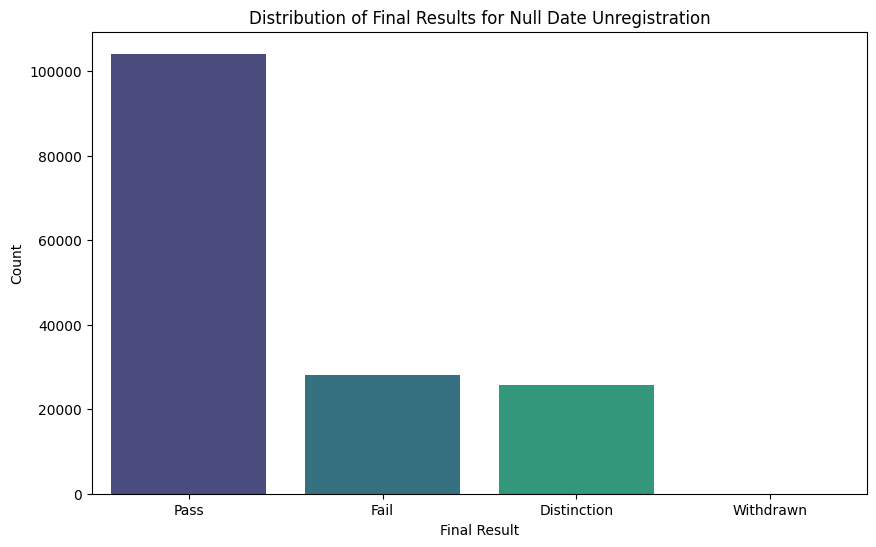

In [123]:
df = student_data_final.copy()

df_null_unregistration = df[df['date_unregistration'].isnull()]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_null_unregistration, x='final_result', palette='viridis')

plt.title('Distribution of Final Results for Null Date Unregistration')
plt.xlabel('Final Result')
plt.ylabel('Count')

plt.show()

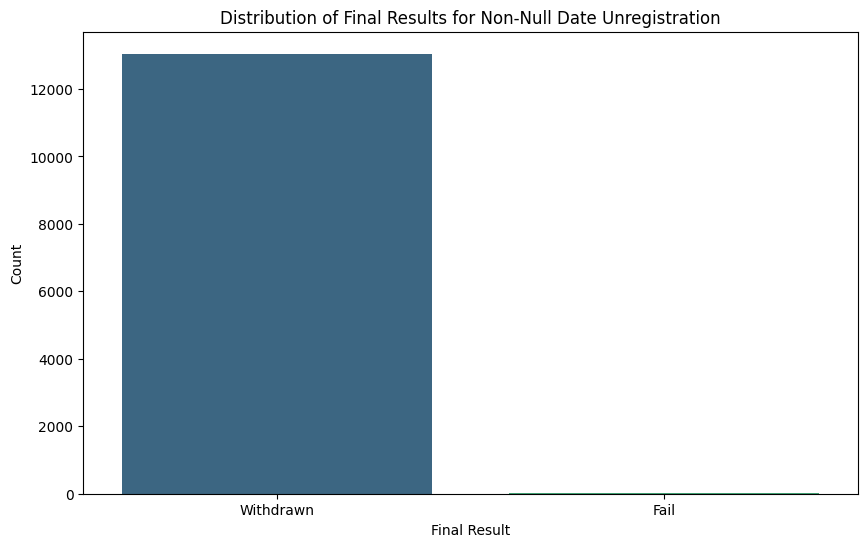

In [124]:
df_non_null_unregistration = df[df['date_unregistration'].notnull()]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_non_null_unregistration, x='final_result', palette='viridis')

plt.title('Distribution of Final Results for Non-Null Date Unregistration')
plt.xlabel('Final Result')
plt.ylabel('Count')

# Show the plot
plt.show()

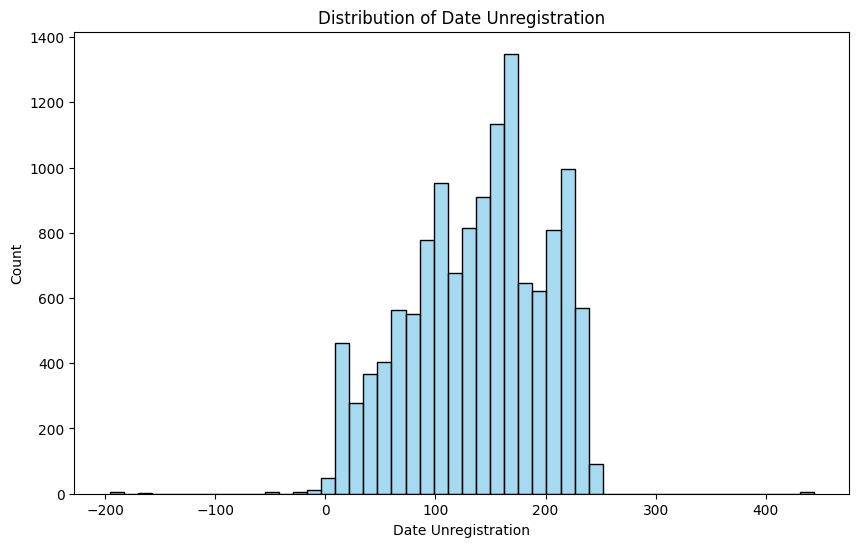

In [125]:
df['study_status'] = df['final_result'].apply(lambda x: 'finished' if x in ['Pass', 'Fail', 'Distinction'] else 'unfinished')

df_non_null = df[df['date_unregistration'].notnull()]

plt.figure(figsize=(10, 6))
sns.histplot(df_non_null['date_unregistration'], bins=50, color='skyblue')

plt.title('Distribution of Date Unregistration')
plt.xlabel('Date Unregistration')
plt.ylabel('Count')

plt.show()

In [126]:
df.isna().sum()

code_module                        0
code_presentation                  0
id_assessment                      0
assessment_type                    0
date                               0
weight                             0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
date_registration                  7
date_unregistration           157992
gender                             0
region                             0
highest_education                  0
imd_band                        7481
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
module_presentation_length         0
study_status                       0
dtype: int64

In [127]:
def categorize_withdrawal(date):
    if pd.isnull(date):
        return "didn't withdraw"
    elif date < 0:
        return 'early withdrawal'
    elif date >=0 and date < 70:
        return 'normal withdrawal'
    else:
        return 'late withdrawal'

df['withdrawal_status'] = df['date_unregistration'].apply(categorize_withdrawal)

df[['date_unregistration', 'withdrawal_status']].head()

,date_unregistration,withdrawal_status
0,NaN,didn't withdraw
1,NaN,didn't withdraw
2,NaN,didn't withdraw
3,NaN,didn't withdraw
4,NaN,didn't withdraw


In [128]:
df.drop(['date_unregistration'],axis=1,inplace=True)

In [129]:
df.isna().sum()

code_module                      0
code_presentation                0
id_assessment                    0
assessment_type                  0
date                             0
weight                           0
id_student                       0
date_submitted                   0
is_banked                        0
score                            0
date_registration                7
gender                           0
region                           0
highest_education                0
imd_band                      7481
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
module_presentation_length       0
study_status                     0
withdrawal_status                0
dtype: int64

In [130]:
regions_list = df[df['imd_band'].isnull()]['region'].unique()

for region in regions_list:
  mode_imd_band = df[df['region'] == region]['imd_band'].mode()[0]
  df.loc[(df['imd_band'].isnull()) & (df['region'] == region), 'imd_band'] = mode_imd_band


df.isna().sum() 
df.dropna(inplace=True)

In [131]:
studentVle

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


In [132]:
vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


In [133]:
student_interaction = studentVle.merge(vle,on=['code_module','code_presentation','id_site'],how="inner")

student_interaction

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
3,AAA,2013J,28400,546614,-10,11,homepage,NaN,NaN
4,AAA,2013J,28400,546714,-10,1,oucontent,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3,homepage,NaN,NaN
10655276,GGG,2014J,675578,896943,269,1,homepage,NaN,NaN
10655277,GGG,2014J,654064,896943,269,3,homepage,NaN,NaN
10655278,GGG,2014J,654064,896939,269,1,forumng,NaN,NaN


In [134]:
grouped_student_interaction = student_interaction.groupby(
    ['id_student', 'code_module', 'code_presentation','activity_type'], as_index=False
)["sum_click"].agg(['sum', 'count'])

grouped_student_interaction

,id_student,code_module,code_presentation,activity_type,sum,count
0,6516,AAA,2014J,dataplus,21,4
1,6516,AAA,2014J,forumng,451,175
2,6516,AAA,2014J,homepage,497,158
3,6516,AAA,2014J,oucontent,1505,184
4,6516,AAA,2014J,resource,31,19
...,...,...,...,...,...,...
240352,2698588,BBB,2014J,oucollaborate,7,7
240353,2698588,BBB,2014J,oucontent,233,74
240354,2698588,BBB,2014J,resource,49,36
240355,2698588,BBB,2014J,subpage,76,34


In [135]:
merged_df = grouped_student_interaction.merge(df,on=['id_student', 'code_module', 'code_presentation'],how='inner')
merged_df

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,study_status,withdrawal_status
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,17,0,60.0,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,51,0,48.0,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,116,0,63.0,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,164,0,61.0,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,210,0,77.0,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579980,2698588,BBB,2014J,url,2,2,15020,TMA,19.0,0.0,18,0,100.0,4.0,F,Yorkshire Region,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
1579981,2698588,BBB,2014J,url,2,2,15021,TMA,54.0,10.0,53,0,85.0,4.0,F,Yorkshire Region,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
1579982,2698588,BBB,2014J,url,2,2,15022,TMA,110.0,20.0,109,0,87.0,4.0,F,Yorkshire Region,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
1579983,2698588,BBB,2014J,url,2,2,15023,TMA,152.0,35.0,152,0,95.0,4.0,F,Yorkshire Region,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw


In [136]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579985 entries, 0 to 1579984
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id_student                  1579985 non-null  int64  
 1   code_module                 1579985 non-null  object 
 2   code_presentation           1579985 non-null  object 
 3   activity_type               1579985 non-null  object 
 4   sum                         1579985 non-null  int64  
 5   count                       1579985 non-null  int64  
 6   id_assessment               1579985 non-null  int64  
 7   assessment_type             1579985 non-null  object 
 8   date                        1579985 non-null  float64
 9   weight                      1579985 non-null  float64
 10  date_submitted              1579985 non-null  int64  
 11  is_banked                   1579985 non-null  int64  
 12  score                       1579985 non-null  float64
 1

In [137]:
merged_df.isna().sum()

id_student                    0
code_module                   0
code_presentation             0
activity_type                 0
sum                           0
count                         0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
date_submitted                0
is_banked                     0
score                         0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
module_presentation_length    0
study_status                  0
withdrawal_status             0
dtype: int64

## data analysis

In [138]:
merged_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_student,1579985.0,709058.613296,557288.970830,6516.0,504819.0,584433.0,634999.0,2698588.0
sum,1579985.0,213.242971,467.777696,1.0,11.0,48.0,203.0,13154.0
count,1579985.0,55.619988,85.525877,1.0,7.0,25.0,68.0,1727.0
id_assessment,1579985.0,27805.969487,8495.165446,1752.0,24289.0,30717.0,34887.0,37443.0
date,1579985.0,135.965156,79.430351,12.0,54.0,131.0,222.0,261.0
weight,1579985.0,11.325690,14.101992,0.0,0.0,9.0,18.0,100.0
date_submitted,1579985.0,115.706554,70.747990,-11.0,51.0,116.0,173.0,608.0
is_banked,1579985.0,0.007204,0.084573,0.0,0.0,0.0,0.0,1.0
score,1579985.0,76.478818,18.138025,0.0,67.0,80.0,90.0,100.0
date_registration,1579985.0,-66.479240,46.909750,-311.0,-95.0,-53.0,-29.0,124.0


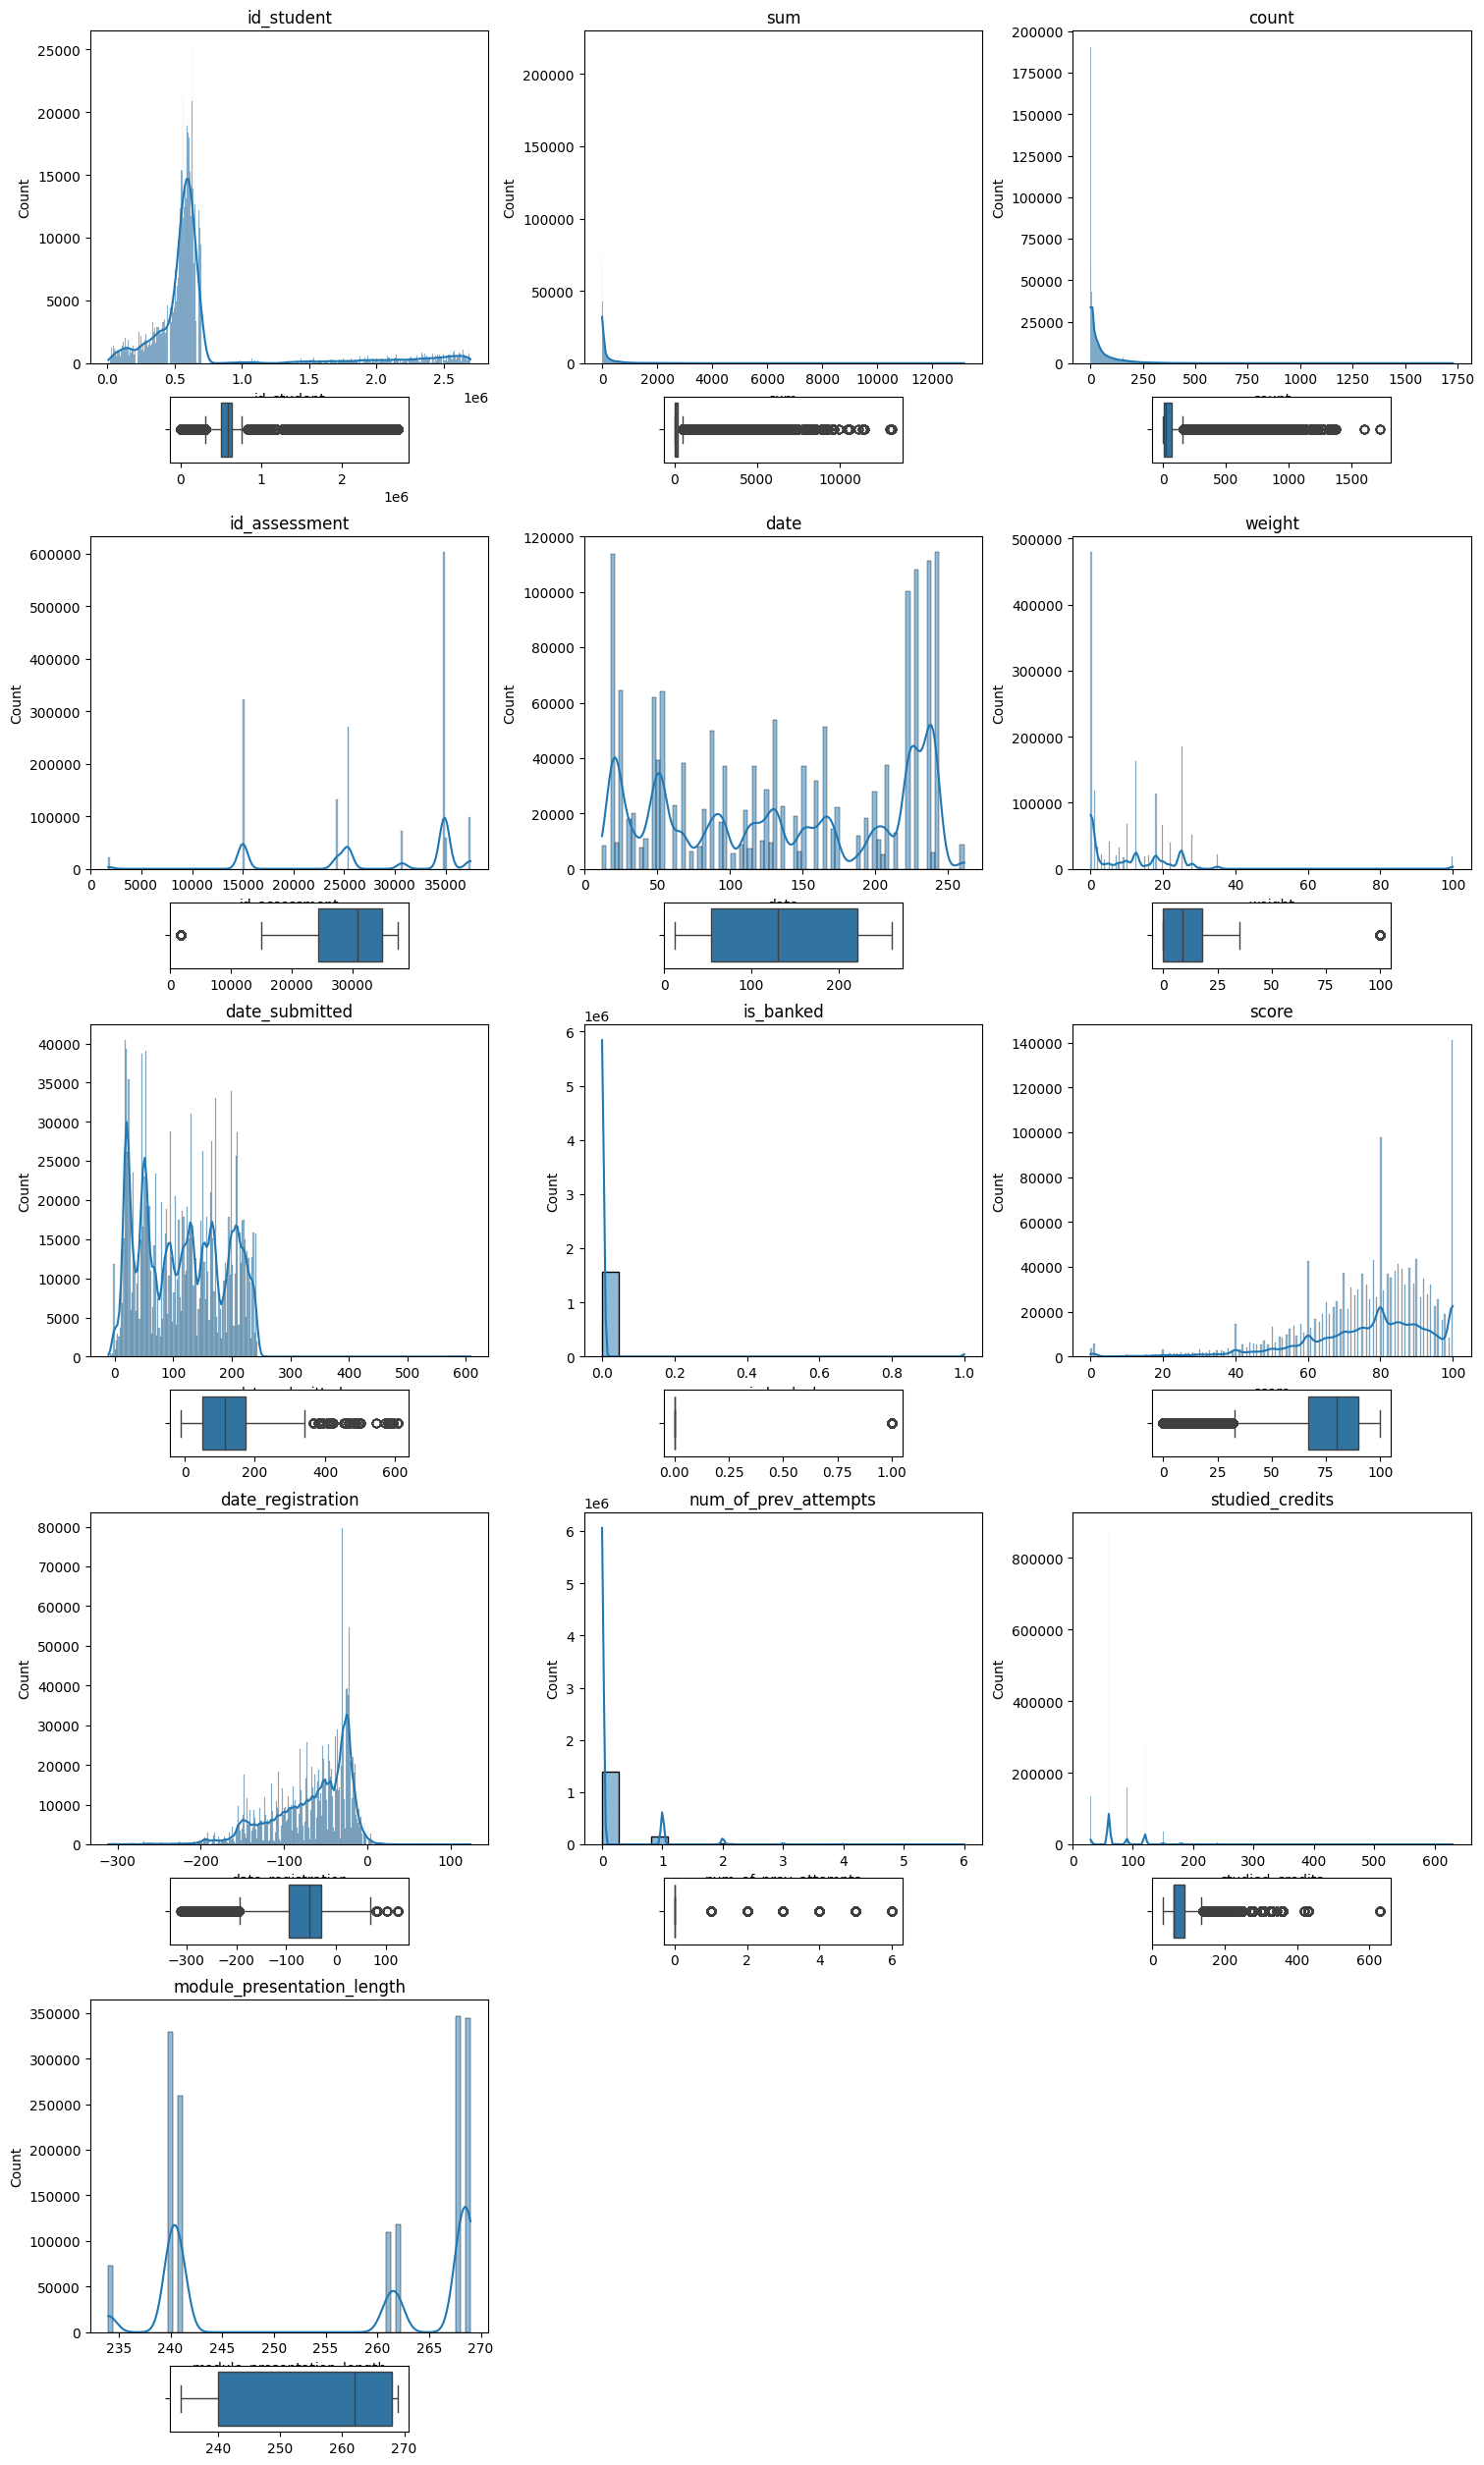

In [139]:
numerical_cols = merged_df.select_dtypes(include='number').columns

num_cols = 3  # Number of columns in the grid
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(merged_df[col], ax=axes[i], kde=True)
    axes[i].set_title(col)

    ax_box = axes[i].inset_axes([0.2, -0.3, 0.6, 0.2])  # [x, y, width, height]
    sns.boxplot(x=merged_df[col], ax=ax_box, orient='h')
    ax_box.set(xlabel='')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.show()

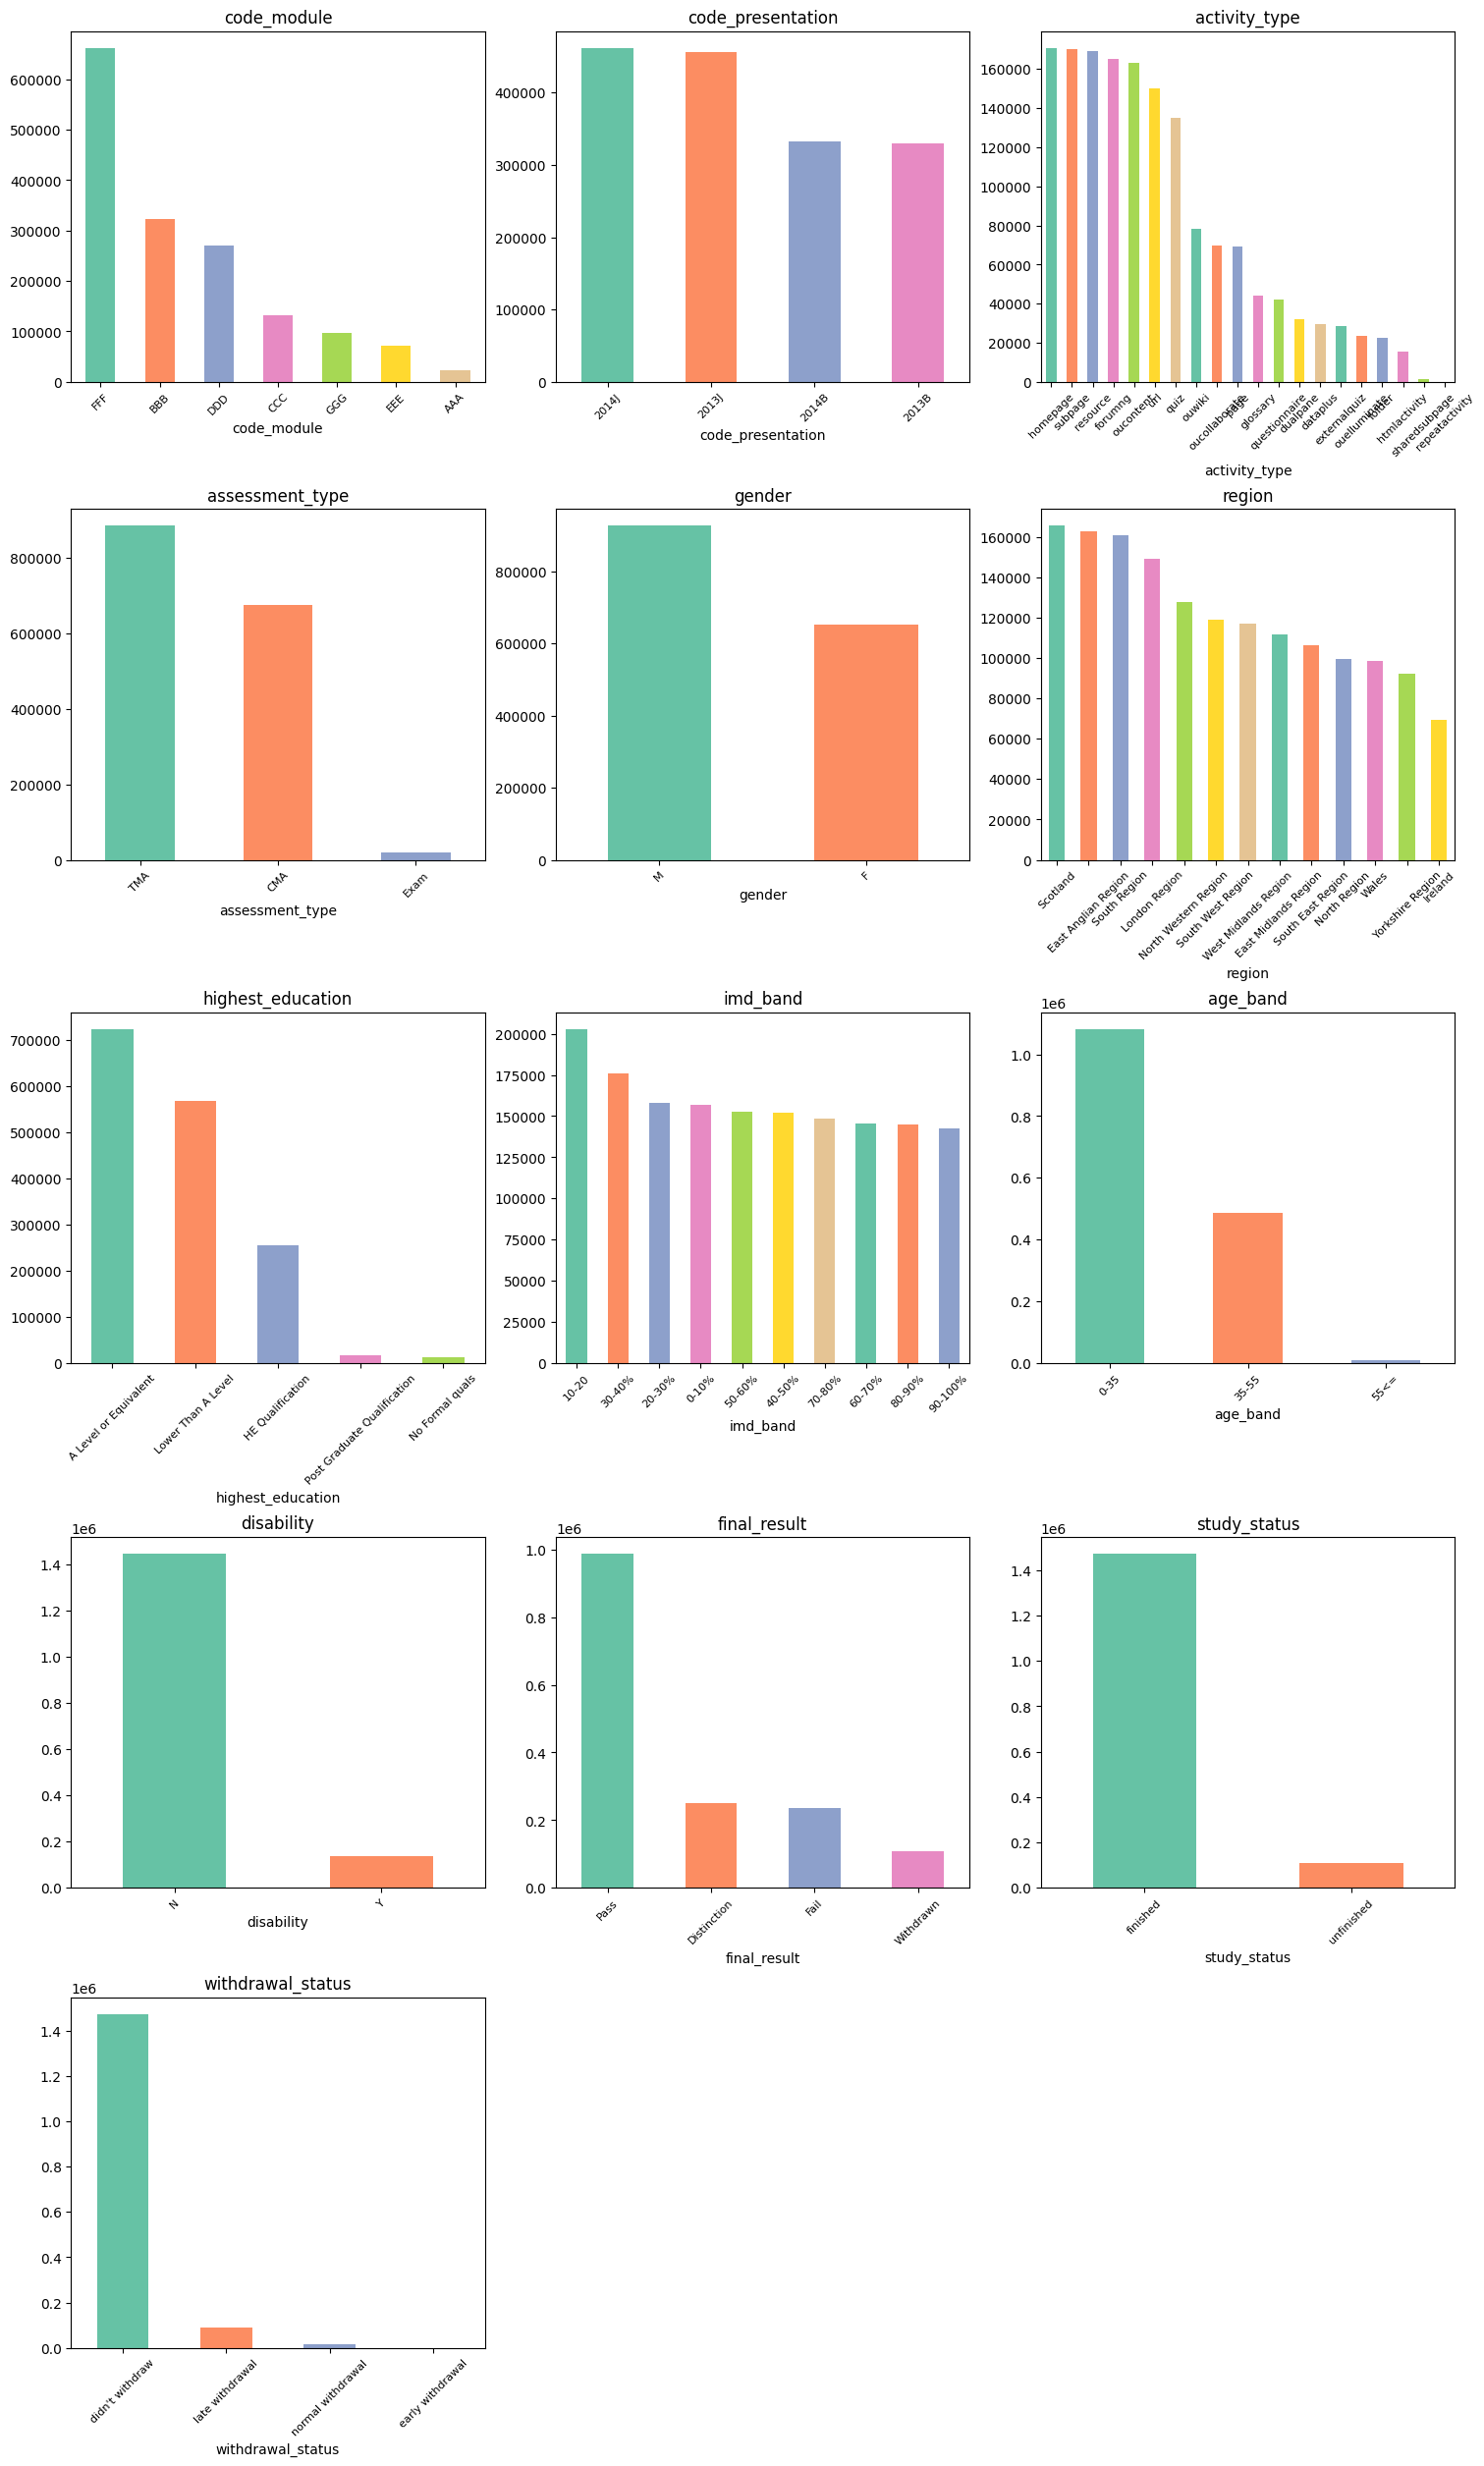

In [140]:
df_cat = merged_df.select_dtypes(exclude=np.number)

num_cols = 3  # Number of columns in the grid
num_rows = (len(df_cat.columns) + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()
palette = sns.color_palette("Set2", len(df_cat.iloc[:, 0].value_counts()))

for i, col in enumerate(df_cat.columns):
    df_cat[col].value_counts().plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
for j in range(len(df_cat.columns), len(axes)):
    fig.delaxes(axes[j])

plt.show()

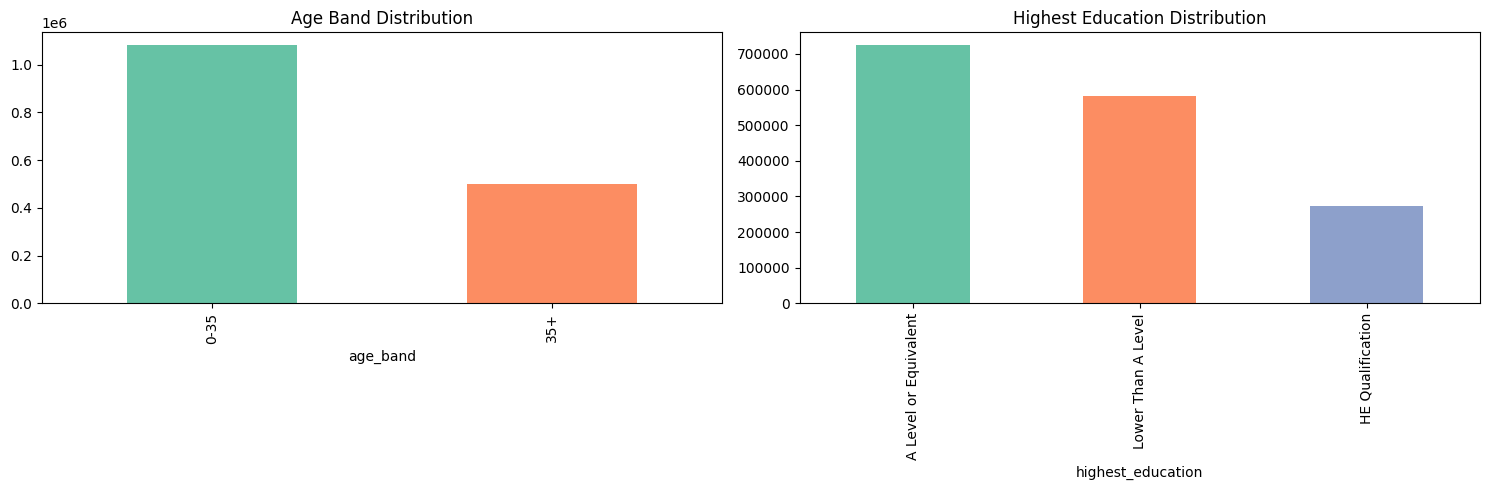

In [141]:
merged_df['highest_education'] = np.where( (merged_df['highest_education'] == 'No Formal quals'),'Lower Than A Level',merged_df['highest_education'])

# Rename post-grads
merged_df['highest_education'] = np.where( (merged_df['highest_education'] == 'Post Graduate Qualification'),'HE Qualification',merged_df['highest_education'])

merged_df['age_band'] = np.where( (merged_df['age_band'] == '55<='), '35+', merged_df['age_band'])

merged_df['age_band'] = np.where( (merged_df['age_band'] == '35-55'),'35+',merged_df['age_band'])



fig, axes = plt.subplots(1, 2, figsize=(15, 5))
palette = sns.color_palette("Set2", len(df_cat[col].value_counts()))

merged_df['age_band'].value_counts().plot(kind='bar', ax=axes[0],color=palette)
axes[0].set_title('Age Band Distribution')

merged_df['highest_education'].value_counts().plot(kind='bar', ax=axes[1],color=palette)
axes[1].set_title('Highest Education Distribution')

plt.tight_layout()
plt.show()

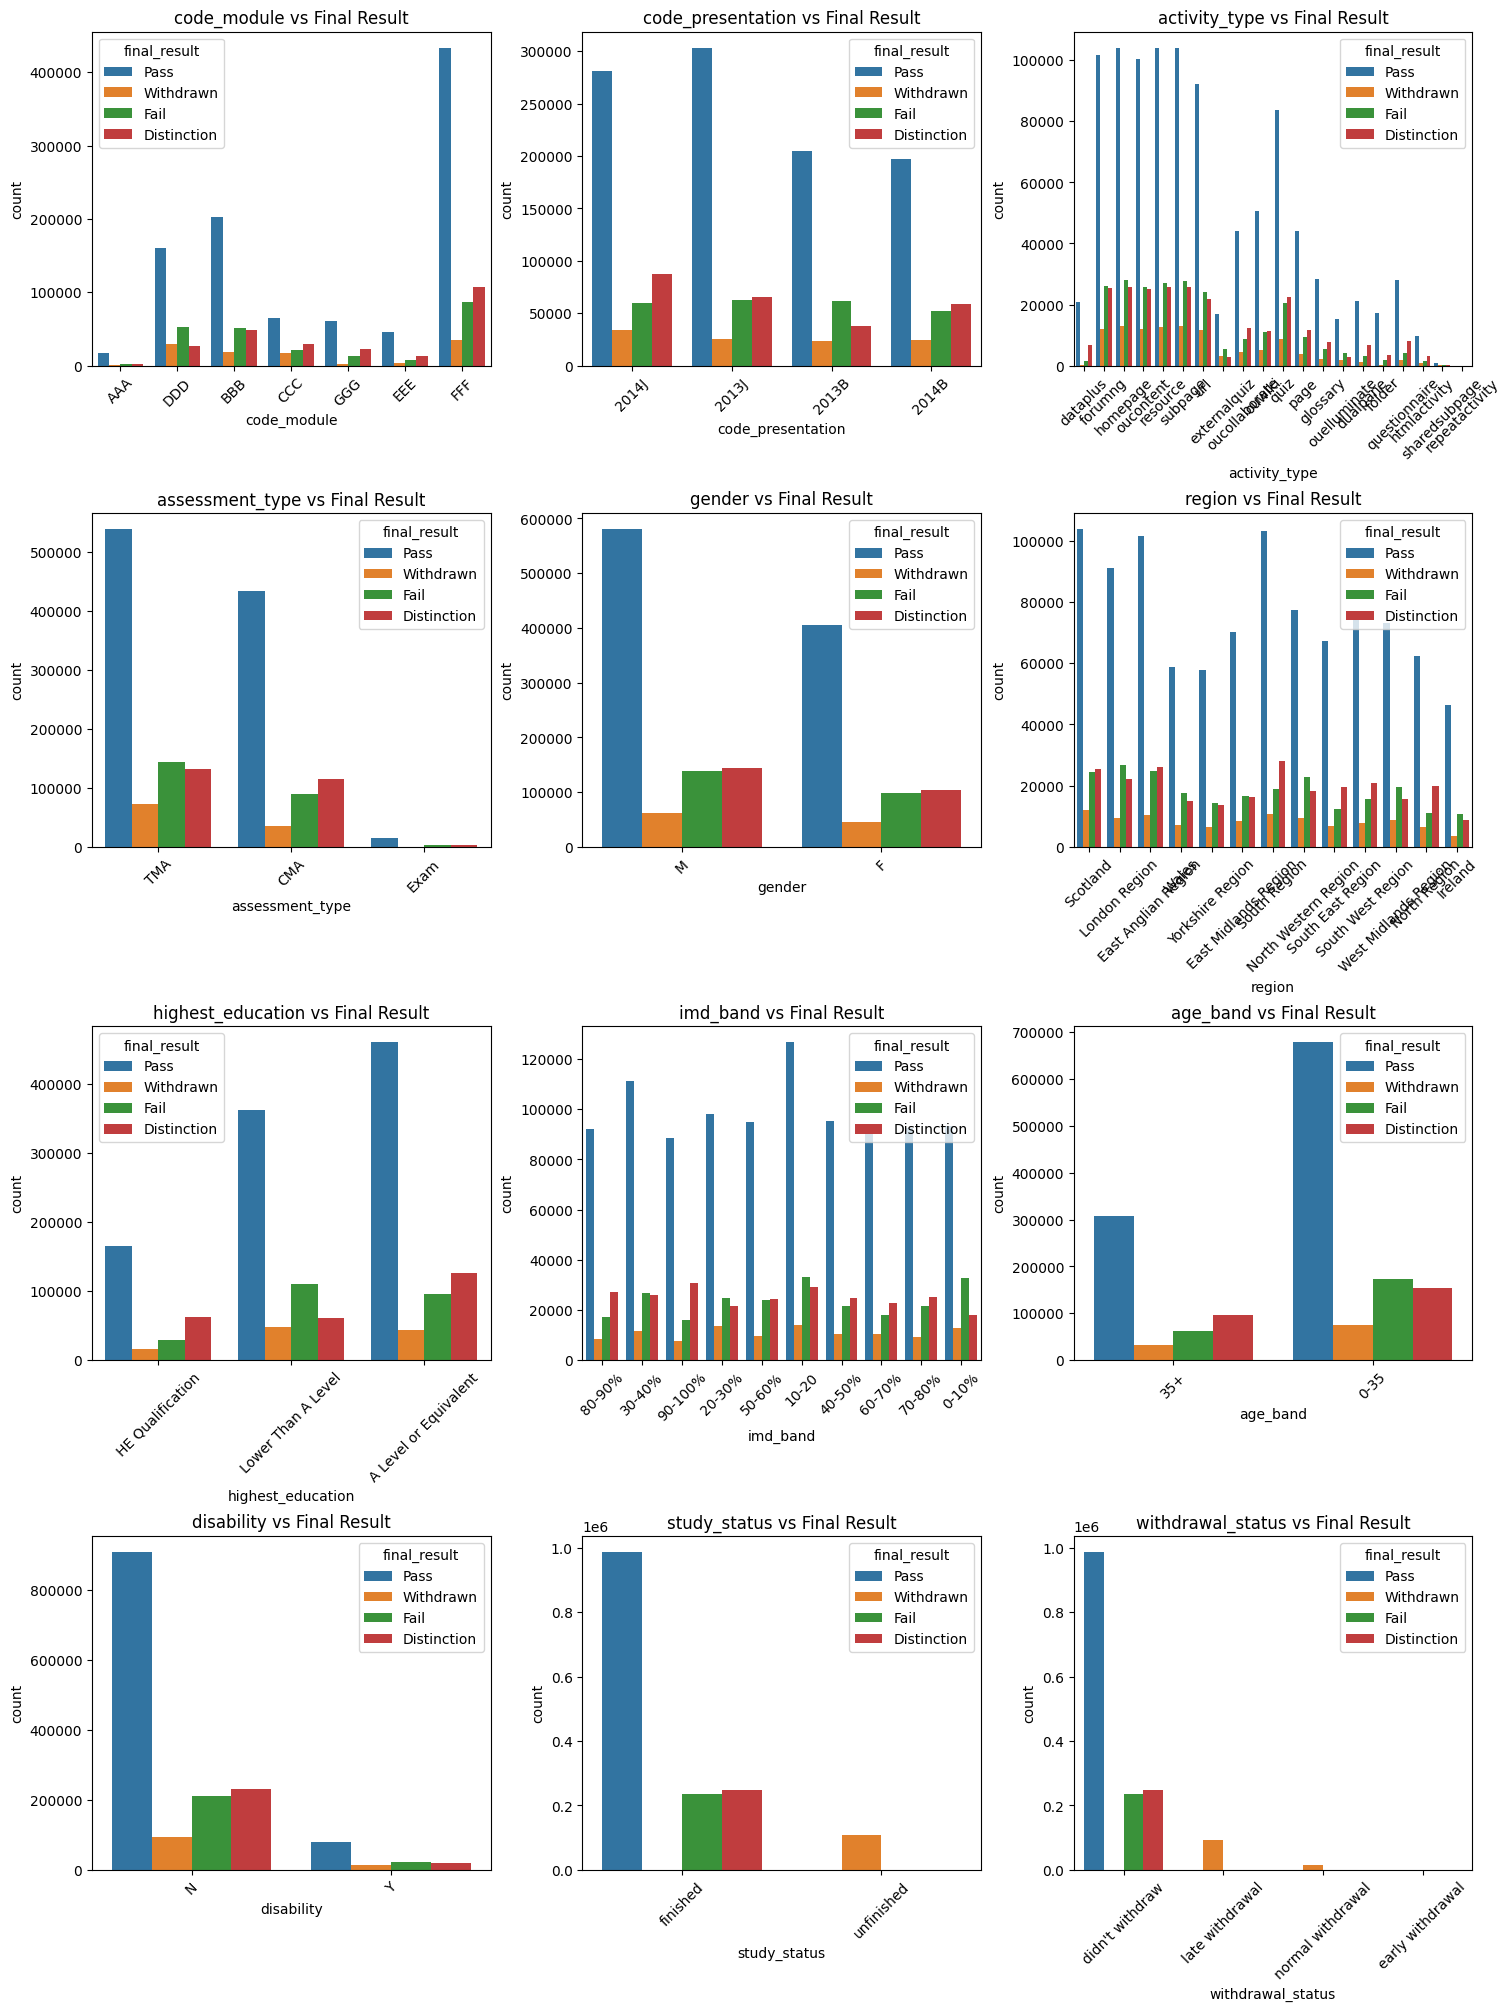

In [143]:
categorical_cols = merged_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('final_result')

num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='final_result', data=merged_df, ax=axes[i])
    axes[i].set_title(f'{col} vs Final Result')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.show()

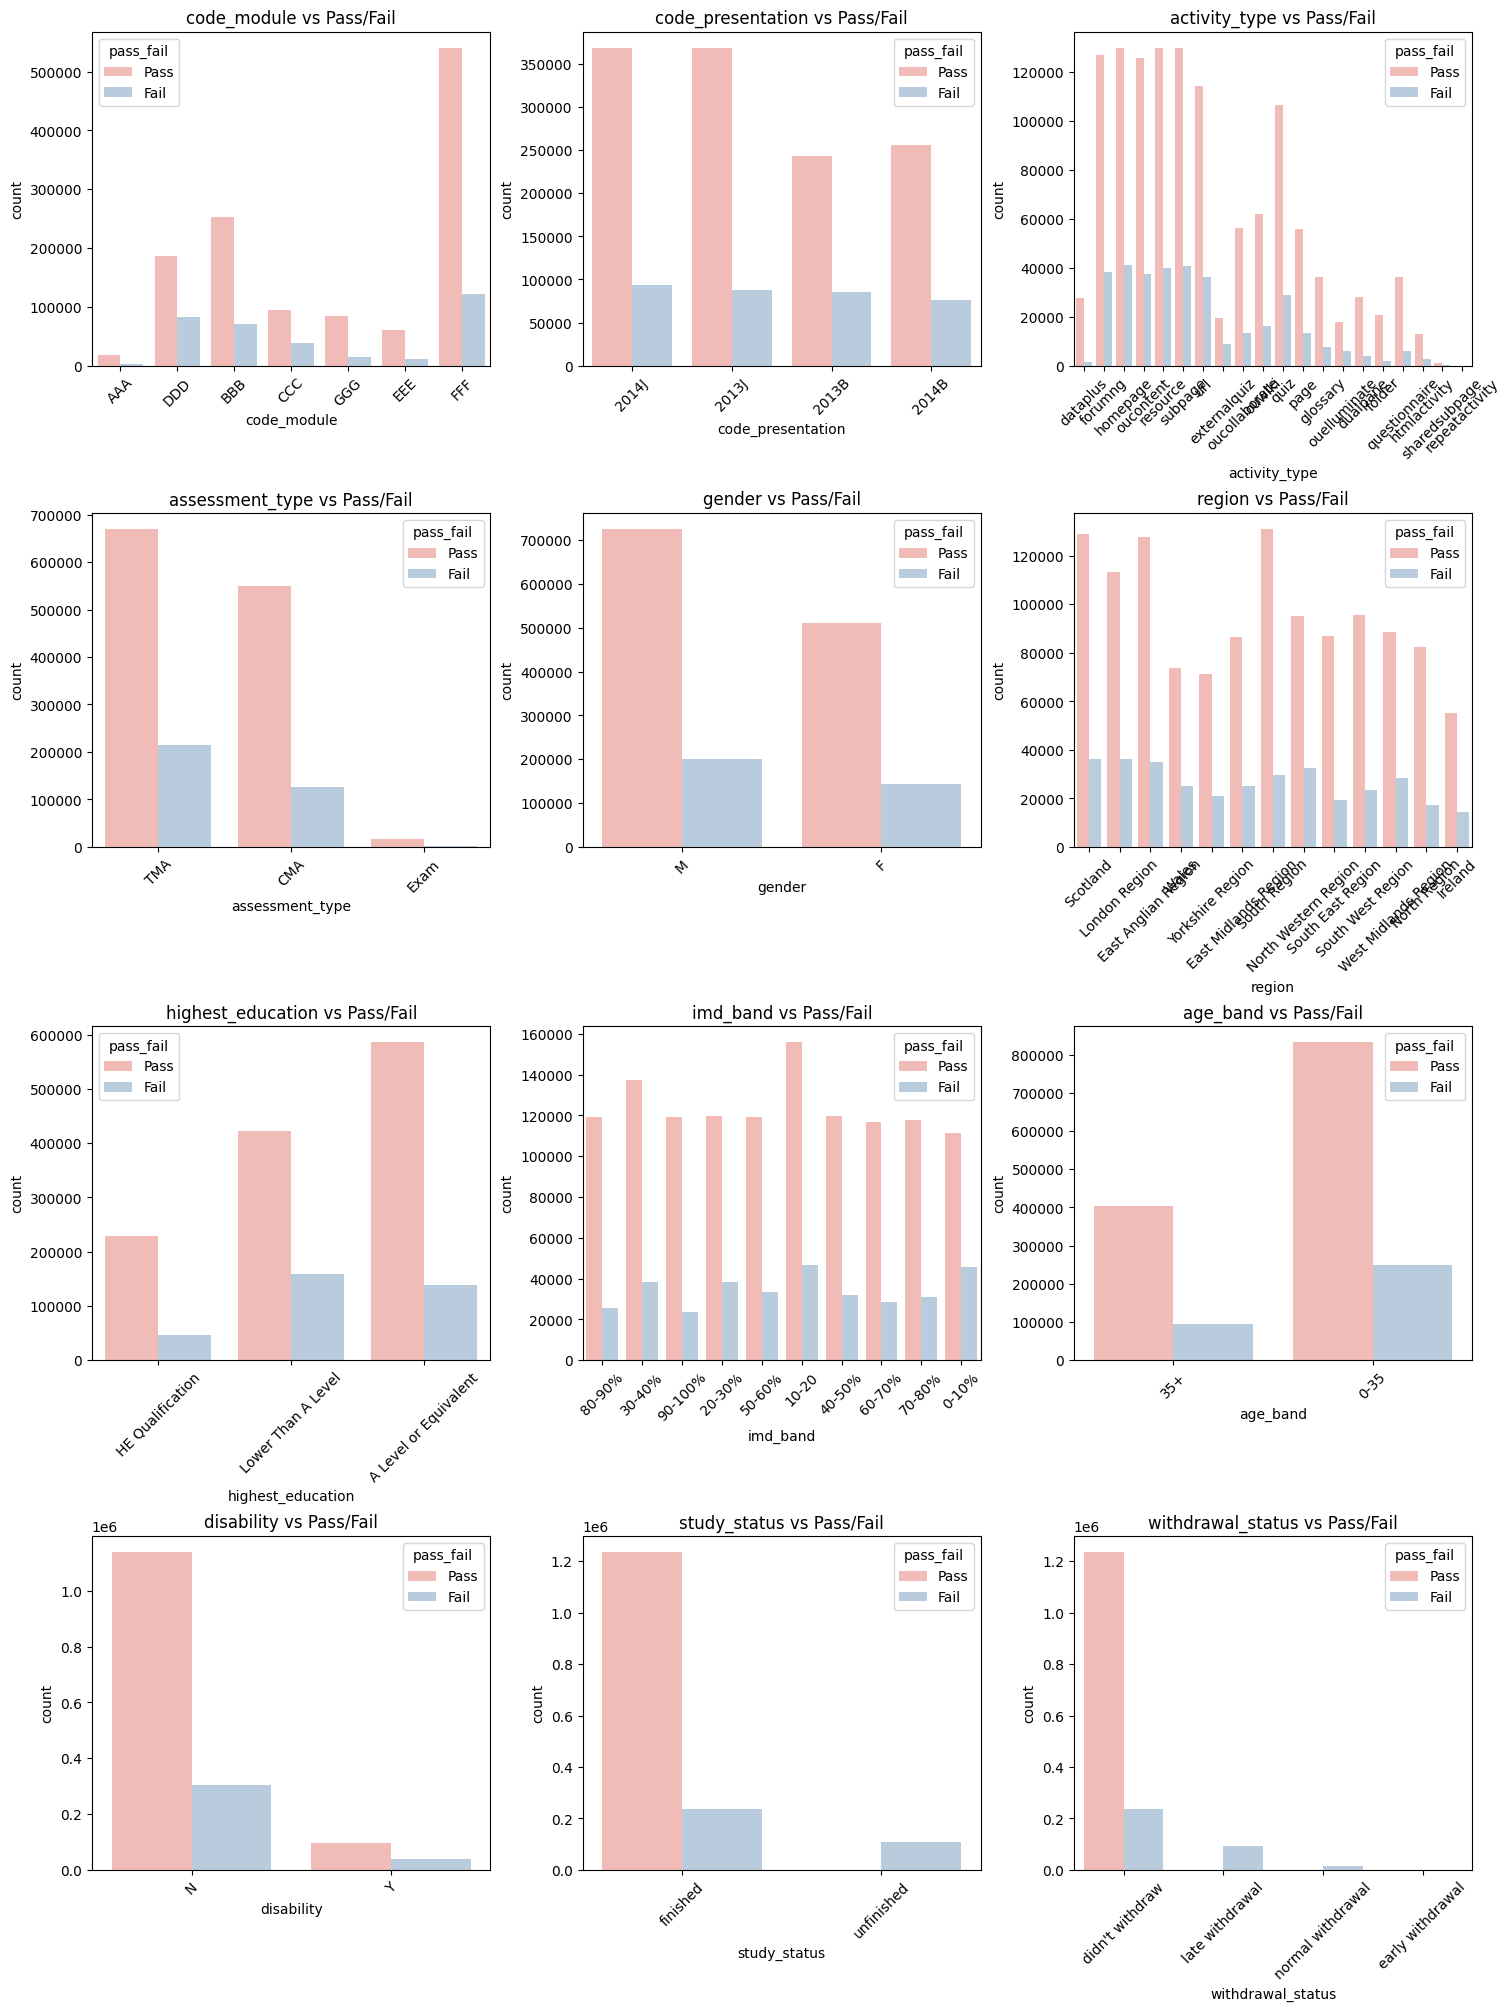

In [144]:
merged_df['pass_fail'] = merged_df['final_result'].apply(lambda x: 'Pass' if x in ['Pass', 'Distinction'] else 'Fail')

# Now let's investigate the relationship between pass_fail and different categorical feats
categorical_cols = merged_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['final_result', 'pass_fail'])

num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='pass_fail', data=merged_df, ax=axes[i],palette="Pastel1")
    axes[i].set_title(f'{col} vs Pass/Fail')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.show()
merged_df.drop(['pass_fail'],axis=1,inplace=True)

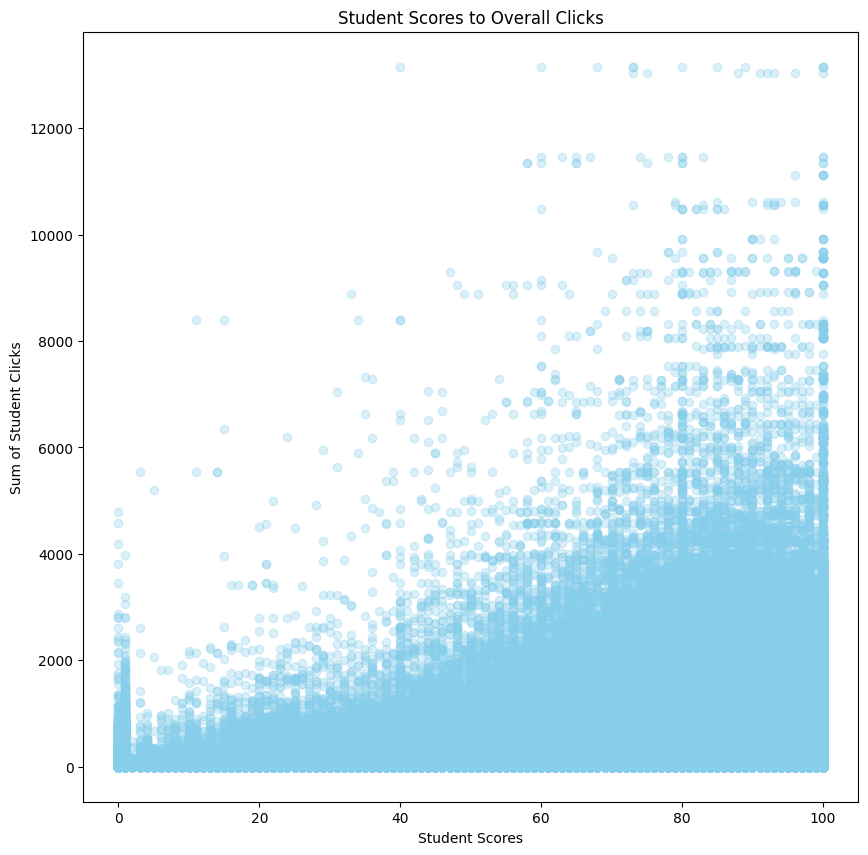

In [145]:
plt.figure(figsize=(10, 10))
plt.title('Student Scores to Overall Clicks')
plt.xlabel("Student Scores")
plt.ylabel("Sum of Student Clicks")
plt.scatter(data=merged_df, y='sum', x='score', alpha=.3,color="skyblue")
plt.show()

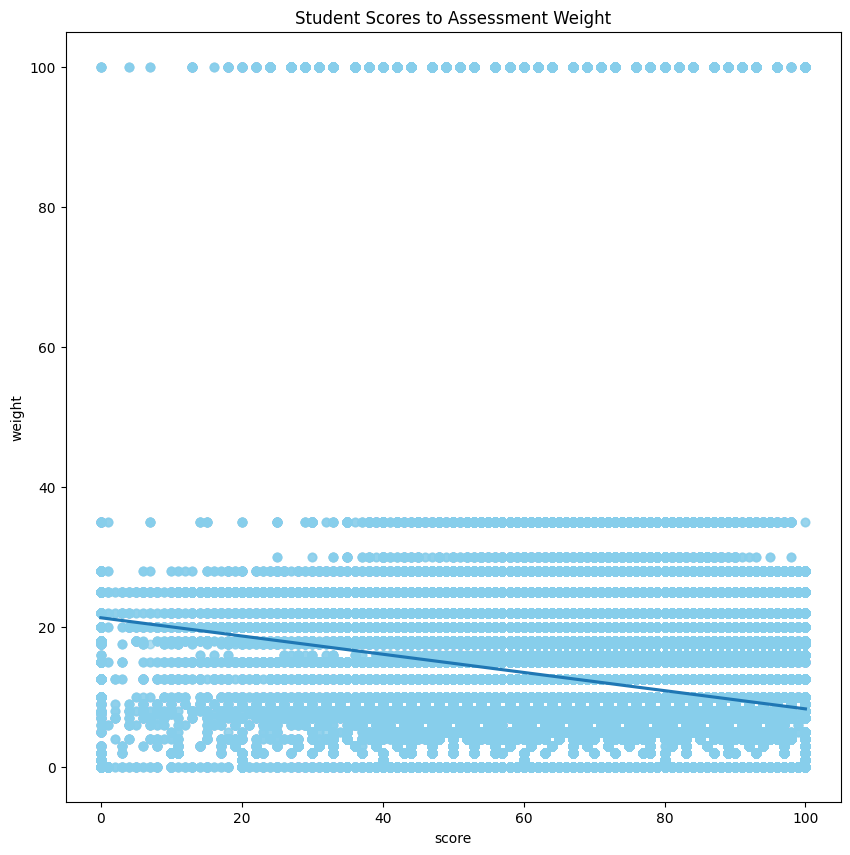

In [146]:
plt.figure(figsize=(10, 10))
plt.title('Student Scores to Assessment Weight')
plt.xlabel("Student Scores")
plt.ylabel("Assessment Weight")
sns.regplot(data=merged_df, y='weight', x='score', scatter_kws={'alpha':0.3, 'color':"skyblue"})
plt.show()

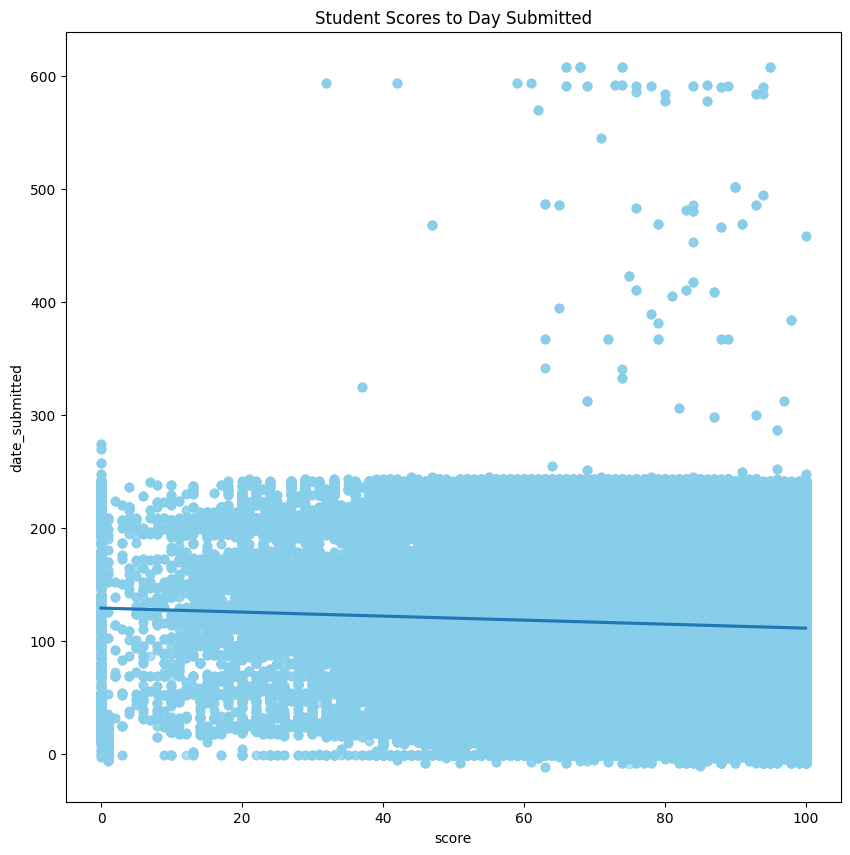

In [147]:
plt.figure(figsize=(10, 10))
plt.title('Student Scores to Day Submitted')
plt.xlabel("Student Scores")
plt.ylabel("Day Submitted")
sns.regplot(data=merged_df, y='date_submitted', x='score', scatter_kws={'alpha':0.3, 'color':"skyblue"})

plt.show()

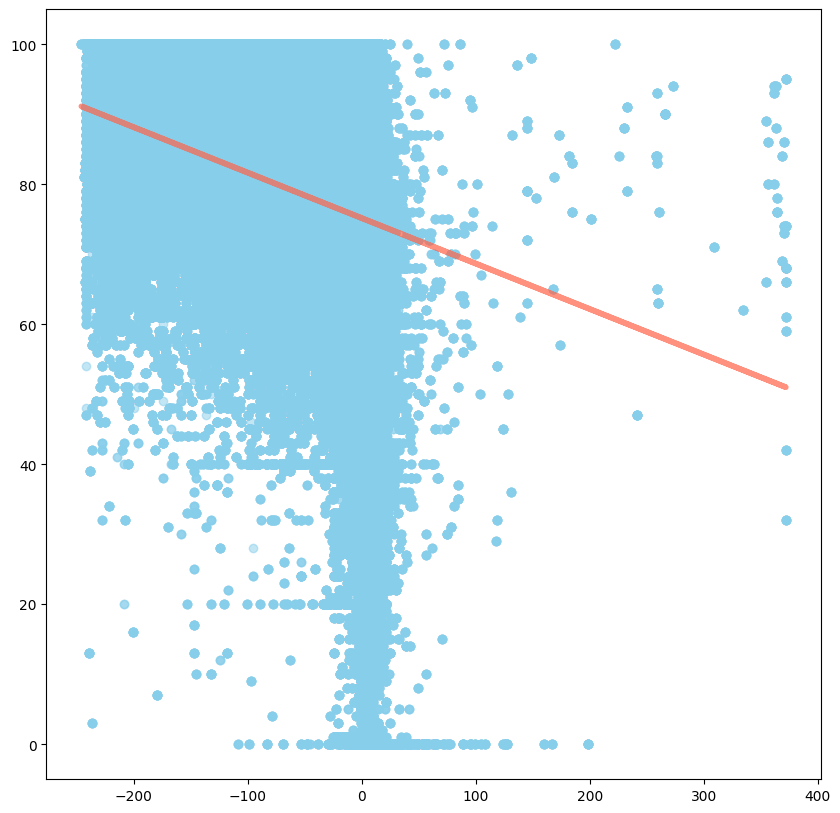

In [148]:
merged_df['days_late'] = merged_df['date_submitted'] - merged_df['date']
lateness_to_score = merged_df['days_late'].astype(int).corr(merged_df['score'].astype(int))

plt.figure(figsize=(10, 10))
x = np.array(merged_df['days_late'].astype(int))
y = np.array(merged_df['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='skyblue')
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)
plt.show()
merged_df.drop('days_late',axis=1,inplace=True)

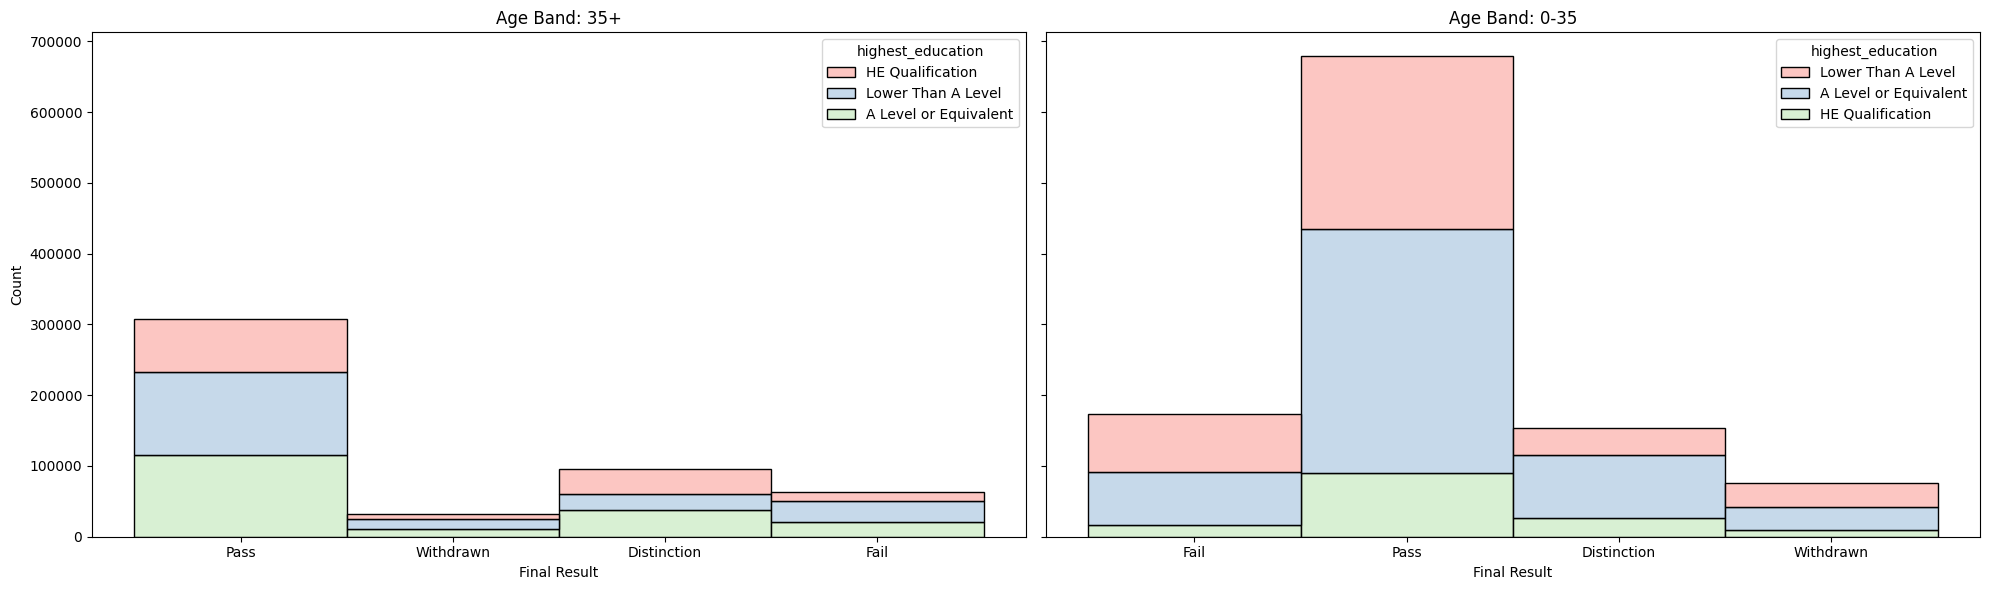

In [149]:
age_bands = merged_df['age_band'].unique()
n_age_bands = len(age_bands)
fig, axes = plt.subplots(nrows=1, ncols=n_age_bands, figsize=(20, 6), sharey=True)

for i, age_band in enumerate(age_bands):
    ax = axes[i]
    subset = merged_df[merged_df['age_band'] == age_band]
    sns.histplot(data=subset, x='final_result', hue='highest_education', multiple='stack', bins=len(merged_df['final_result'].unique()), ax=ax, palette='Pastel1')
    ax.set_title(f'Age Band: {age_band}')
    ax.set_xlabel('Final Result')
    if i == 0:
        ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [150]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579985 entries, 0 to 1579984
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id_student                  1579985 non-null  int64  
 1   code_module                 1579985 non-null  object 
 2   code_presentation           1579985 non-null  object 
 3   activity_type               1579985 non-null  object 
 4   sum                         1579985 non-null  int64  
 5   count                       1579985 non-null  int64  
 6   id_assessment               1579985 non-null  int64  
 7   assessment_type             1579985 non-null  object 
 8   date                        1579985 non-null  float64
 9   weight                      1579985 non-null  float64
 10  date_submitted              1579985 non-null  int64  
 11  is_banked                   1579985 non-null  int64  
 12  score                       1579985 non-null  float64
 1

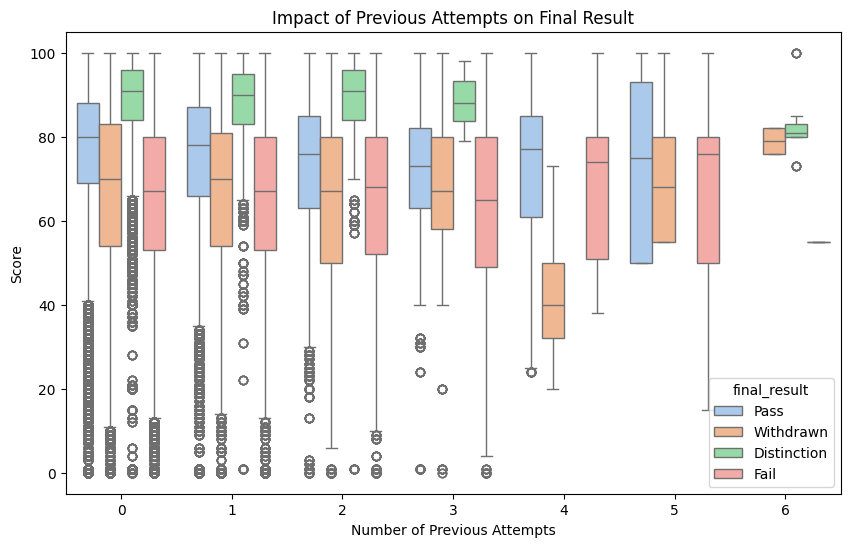

In [151]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x="num_of_prev_attempts", y="score", hue="final_result", palette='pastel')

plt.title("Impact of Previous Attempts on Final Result")
plt.xlabel("Number of Previous Attempts")
plt.ylabel("Score")

plt.show()

## importing modules and reading data

In [152]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [153]:
df = merged_df
df.shape

(1579985, 26)

In [154]:
df.head()

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,study_status,withdrawal_status
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,17,0,60.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,51,0,48.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,116,0,63.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,164,0,61.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,210,0,77.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw


In [155]:
df.describe()

,id_student,sum,count,id_assessment,date,weight,date_submitted,is_banked,score,date_registration,num_of_prev_attempts,studied_credits,module_presentation_length
count,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06,1.579985e+06
mean,7.090586e+05,2.132430e+02,5.561999e+01,2.780597e+04,1.359652e+02,1.132569e+01,1.157066e+02,7.204499e-03,7.647882e+01,-6.647924e+01,1.407032e-01,7.836183e+01,2.554512e+02
std,5.572890e+05,4.677777e+02,8.552588e+01,8.495165e+03,7.943035e+01,1.410199e+01,7.074799e+01,8.457304e-02,1.813803e+01,4.690975e+01,4.368678e-01,3.680519e+01,1.360592e+01
min,6.516000e+03,1.000000e+00,1.000000e+00,1.752000e+03,1.200000e+01,0.000000e+00,-1.100000e+01,0.000000e+00,0.000000e+00,-3.110000e+02,0.000000e+00,3.000000e+01,2.340000e+02
25%,5.048190e+05,1.100000e+01,7.000000e+00,2.428900e+04,5.400000e+01,0.000000e+00,5.100000e+01,0.000000e+00,6.700000e+01,-9.500000e+01,0.000000e+00,6.000000e+01,2.400000e+02
50%,5.844330e+05,4.800000e+01,2.500000e+01,3.071700e+04,1.310000e+02,9.000000e+00,1.160000e+02,0.000000e+00,8.000000e+01,-5.300000e+01,0.000000e+00,6.000000e+01,2.620000e+02
75%,6.349990e+05,2.030000e+02,6.800000e+01,3.488700e+04,2.220000e+02,1.800000e+01,1.730000e+02,0.000000e+00,9.000000e+01,-2.900000e+01,0.000000e+00,9.000000e+01,2.680000e+02
max,2.698588e+06,1.315400e+04,1.727000e+03,3.744300e+04,2.610000e+02,1.000000e+02,6.080000e+02,1.000000e+00,1.000000e+02,1.240000e+02,6.000000e+00,6.300000e+02,2.690000e+02


In [156]:
df.isnull().sum()

id_student                    0
code_module                   0
code_presentation             0
activity_type                 0
sum                           0
count                         0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
date_submitted                0
is_banked                     0
score                         0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
module_presentation_length    0
study_status                  0
withdrawal_status             0
dtype: int64

## feature engineering

In [157]:
df['assessment_engagement_score'] = df['sum'] * df['count']
df['submission_timeliness'] = df['date_submitted'] - df['date']
df['score_per_weight'] = df['score'] / (df['weight'] + 1)
df['module_engagement_rate'] = df['sum'] / df['module_presentation_length']

In [158]:
df['repeat_student'] = df['num_of_prev_attempts'].apply(lambda x: 1 if x > 0 else 0)
df['performance_by_registration'] = df['score'] / (df['date_registration'] + 1)
df['banked_assessment_ratio'] = df.groupby('id_student')['is_banked'].transform(lambda x: x.sum() / x.count())
df['time_since_registration'] = df['date'] - df['date_registration']
df['weighted_engagement'] = df['assessment_engagement_score'] * df['weight']
df['cumulative_score'] = df.groupby('id_student')['score'].cumsum()

In [159]:
df['engagement_consistency'] = df.groupby('id_student')['sum'].transform(np.std)
df['learning_pace'] = df.groupby('id_student')['date_submitted'].diff().fillna(0)
df['engagement_dropoff'] = df.groupby('id_student')['sum'].transform(lambda x: (x.max() - x.min()) / (x.count() - 1) if x.count() > 1 else 0)
df['activity_diversity'] = df.groupby('id_student')['activity_type'].transform('nunique')

In [160]:
df['improvement_rate'] = df.groupby('id_student')['score'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / (x.count() - 1) if x.count() > 1 else 0)

In [161]:
def determine_study_method(activity_type_counts):
    threshold = 5
    
    poor_conditions = (
        activity_type_counts.get('homepage', 0) < threshold and
        activity_type_counts.get('subpage', 0) < threshold and
        activity_type_counts.get('resource', 0) < threshold and
        activity_type_counts.get('forumng', 0) < threshold and
        activity_type_counts.get('oucontent', 0) < threshold and
        activity_type_counts.get('url', 0) < threshold and
        activity_type_counts.get('quiz', 0) < threshold and
        activity_type_counts.get('ouwiki', 0) < threshold and
        activity_type_counts.get('oucollaborate', 0) < threshold and
        activity_type_counts.get('page', 0) < threshold and
        activity_type_counts.get('glossary', 0) < threshold and
        activity_type_counts.get('questionnaire', 0) < threshold and
        activity_type_counts.get('dualpane', 0) < threshold and
        activity_type_counts.get('dataplus', 0) < threshold and
        activity_type_counts.get('externalquiz', 0) < threshold and
        activity_type_counts.get('ouelluminate', 0) < threshold and
        activity_type_counts.get('folder', 0) < threshold and
        activity_type_counts.get('htmlactivity', 0) < threshold and
        activity_type_counts.get('sharedsubpage', 0) < threshold and
        activity_type_counts.get('repeatactivity', 0) < threshold
    )
    
    
    interactive_conditions = (
        (activity_type_counts.get('quiz', 0) > threshold and
        activity_type_counts.get('externalquiz', 0) > threshold) or
        activity_type_counts.get('repeatactivity', 0) > threshold or
        activity_type_counts.get('questionnaire', 0) > threshold
    )
    
    resource_based_conditions = (
        activity_type_counts.get('resource', 0) > threshold or
        activity_type_counts.get('homepage', 0) > threshold or
        activity_type_counts.get('folder', 0) > threshold or
        activity_type_counts.get('subpage', 0) > threshold or
        activity_type_counts.get('url', 0) > threshold or
        activity_type_counts.get('page', 0) > threshold or
        activity_type_counts.get('glossary', 0) > threshold or
        activity_type_counts.get('dataplus', 0) > threshold or
        activity_type_counts.get('dualpane', 0) > threshold or
        activity_type_counts.get('htmlactivity', 0) > threshold
    )
    
    collaborative_conditions = (
        activity_type_counts.get('ouelluminate', 0) > threshold or
        activity_type_counts.get('ouwiki', 0) > threshold or
        activity_type_counts.get('sharedsubpage', 0) > threshold or
        activity_type_counts.get('oucontent', 0) > threshold or
        activity_type_counts.get('page', 0) > threshold or
        activity_type_counts.get('oucollaborate', 0) > threshold
    )
    
    
    if poor_conditions and not (collaborative_conditions or interactive_conditions or resource_based_conditions):
        return 'Offline Content'    
    elif collaborative_conditions and not interactive_conditions:
        return 'Collaborative'
    elif resource_based_conditions and not (collaborative_conditions or interactive_conditions):
        return 'Resource-Based'
    elif interactive_conditions:
        return 'Interactive'
    else:
        return 'Informational'

activity_type_counts = df.groupby('id_student')['activity_type'].value_counts().unstack().fillna(0)

activity_type_counts['study_method_preference'] = activity_type_counts.apply(determine_study_method, axis=1)

if 'study_method_preference' in df.columns:
    df = df.drop(columns=['study_method_preference'])

df = df.merge(activity_type_counts[['study_method_preference']], on='id_student', how='left')

df.head()

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,study_status,withdrawal_status,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,banked_assessment_ratio,time_since_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate,study_method_preference
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,17,0,60.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-2.0,5.454545,0.078067,0,-1.176471,0.0,71.0,840.0,60.0,491.833818,0.0,43.647059,7,0.5,Informational
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,51,0,48.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-3.0,2.285714,0.078067,0,-0.941176,0.0,106.0,1680.0,108.0,491.833818,34.0,43.647059,7,0.5,Informational
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,116,0,63.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-1.0,3.000000,0.078067,0,-1.235294,0.0,169.0,1680.0,171.0,491.833818,65.0,43.647059,7,0.5,Informational
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,164,0,61.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-2.0,2.904762,0.078067,0,-1.196078,0.0,218.0,1680.0,232.0,491.833818,48.0,43.647059,7,0.5,Informational
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,210,0,77.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-5.0,2.483871,0.078067,0,-1.509804,0.0,267.0,2520.0,309.0,491.833818,46.0,43.647059,7,0.5,Informational


In [162]:
df.study_method_preference.value_counts()

study_method_preference
Collaborative      772968
Interactive        533003
Offline Content    144926
Informational      103136
Resource-Based      25952
Name: count, dtype: int64

In [163]:
summary_columns = {
    'code_module': lambda x: x.mode()[0],
    'code_presentation': lambda x: x.mode()[0],
    'activity_type': lambda x: x.mode()[0],
    'sum': 'sum',
    'count': 'sum',
    'assessment_type': lambda x: x.mode()[0],
    'date': 'mean',
    'weight': 'mean',
    'date_submitted':'mean',
    'is_banked': lambda x: x.mode()[0],
    'score':'mean',
    'date_registration':'mean',
    'gender': lambda x: x.mode()[0],
    'region': lambda x: x.mode()[0],
    'highest_education': lambda x: x.mode()[0],
    'imd_band' : lambda x: x.mode()[0],
    'age_band': lambda x: x.mode()[0],
    'num_of_prev_attempts': 'mean',
    'studied_credits': 'mean',
    'disability': lambda x: x.mode()[0],
    'final_result': lambda x: x.mode()[0],
    'module_presentation_length': 'mean',
    'study_status': lambda x: x.mode()[0],
    'withdrawal_status': lambda x: x.mode()[0],
    'assessment_engagement_score': 'mean',
    'submission_timeliness': 'mean',
    'score_per_weight': 'mean',
    'module_engagement_rate':'mean',
    'repeat_student': 'mean',
    'performance_by_registration': 'mean',
    'banked_assessment_ratio': 'mean',
    'time_since_registration': 'mean',
    'weighted_engagement': 'mean',
    'cumulative_score': 'mean',
    'engagement_consistency': 'mean',
    'learning_pace': 'mean',
    'engagement_dropoff': 'mean',
    'activity_diversity': 'mean',
    'improvement_rate': 'mean',
    'study_method_preference': lambda x: x.mode()[0]
}

# Group by 'id_student' and aggregate
summary_df = df.groupby('id_student').agg(summary_columns).reset_index()

In [164]:
ids = summary_df["id_student"]
study_method = summary_df["study_method_preference"]

In [165]:
columns_to_work_with = ['activity_type','sum','count','score','gender','region','highest_education','imd_band','age_band'
           ,'num_of_prev_attempts','disability','final_result','study_status','withdrawal_status','assessment_engagement_score'
           ,'submission_timeliness','score_per_weight','module_engagement_rate','repeat_student','performance_by_registration'
           ,'weighted_engagement','cumulative_score','engagement_consistency','learning_pace','engagement_dropoff'
           ,'activity_diversity','improvement_rate']

In [166]:
summary_df = summary_df[columns_to_work_with]

summary_df.shape

(23343, 27)

## scaling and encoding

In [167]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

numerical_cols = summary_df.select_dtypes(include=[np.number]).columns

numerical_data = summary_df[numerical_cols].copy()

numerical_data.replace([np.inf, -np.inf], np.nan, inplace=True)
numerical_data.fillna(0, inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numerical_data)

scaled_data_df = pd.DataFrame(scaled_data, columns=numerical_cols)
#scaled_data_df.drop(columns='id_student', inplace=True)
scaled_data_df.head()

,sum,count,score,num_of_prev_attempts,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate
0,0.046918,0.055064,0.618000,0.000000,0.027572,0.584637,0.032258,0.156095,0.000000,0.496875,0.038912,0.073336,0.118661,0.470793,0.097390,0.400000,0.644654
1,0.006647,0.015226,0.873077,0.051282,0.001379,0.544713,0.070656,0.020121,0.307692,0.497121,0.001298,0.116558,0.017075,0.349810,0.013270,0.533333,0.623966
2,0.015699,0.016291,0.820000,0.000000,0.004209,0.586641,0.043282,0.060931,0.000000,0.500565,0.005940,0.084399,0.046766,0.489130,0.042164,0.333333,0.633268
3,0.002162,0.003911,0.825000,0.333333,0.000268,0.599917,0.286206,0.013771,1.000000,0.493776,0.000118,0.058792,0.007565,0.363658,0.009982,0.266667,0.567693
4,0.024475,0.040586,0.737500,0.000000,0.003367,0.593967,0.087350,0.044251,0.000000,0.499725,0.002970,0.160185,0.043693,0.420277,0.020365,0.466667,0.623440


In [168]:
categorical_cols = summary_df.select_dtypes(exclude=[np.number]).columns
categorical_data = summary_df[categorical_cols]

merged_data = pd.concat([scaled_data_df, categorical_data], axis=1)
merged_data.head()

,sum,count,score,num_of_prev_attempts,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate,activity_type,gender,region,highest_education,imd_band,age_band,disability,final_result,study_status,withdrawal_status
0,0.046918,0.055064,0.618000,0.000000,0.027572,0.584637,0.032258,0.156095,0.000000,0.496875,0.038912,0.073336,0.118661,0.470793,0.097390,0.400000,0.644654,dataplus,M,Scotland,HE Qualification,80-90%,35+,N,Pass,finished,didn't withdraw
1,0.006647,0.015226,0.873077,0.051282,0.001379,0.544713,0.070656,0.020121,0.307692,0.497121,0.001298,0.116558,0.017075,0.349810,0.013270,0.533333,0.623966,forumng,M,London Region,HE Qualification,30-40%,35+,N,Withdrawn,unfinished,late withdrawal
2,0.015699,0.016291,0.820000,0.000000,0.004209,0.586641,0.043282,0.060931,0.000000,0.500565,0.005940,0.084399,0.046766,0.489130,0.042164,0.333333,0.633268,forumng,M,East Anglian Region,HE Qualification,90-100%,35+,N,Pass,finished,didn't withdraw
3,0.002162,0.003911,0.825000,0.333333,0.000268,0.599917,0.286206,0.013771,1.000000,0.493776,0.000118,0.058792,0.007565,0.363658,0.009982,0.266667,0.567693,forumng,F,East Anglian Region,Lower Than A Level,20-30%,0-35,N,Fail,finished,didn't withdraw
4,0.024475,0.040586,0.737500,0.000000,0.003367,0.593967,0.087350,0.044251,0.000000,0.499725,0.002970,0.160185,0.043693,0.420277,0.020365,0.466667,0.623440,forumng,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,N,Pass,finished,didn't withdraw


In [169]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = merged_data.select_dtypes(include="object").columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # To keep other columns unchanged
)

final_data_encoded = preprocessor.fit_transform(merged_data)

feature_names = (preprocessor
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_cols))

all_feature_names = feature_names.tolist() + [col for col in merged_data.columns if col not in categorical_cols]

final_data_encoded_df = pd.DataFrame(final_data_encoded, columns=all_feature_names)

final_data_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23343 entries, 0 to 23342
Data columns (total 68 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   activity_type_dataplus                   23343 non-null  float64
 1   activity_type_dualpane                   23343 non-null  float64
 2   activity_type_externalquiz               23343 non-null  float64
 3   activity_type_folder                     23343 non-null  float64
 4   activity_type_forumng                    23343 non-null  float64
 5   activity_type_glossary                   23343 non-null  float64
 6   activity_type_homepage                   23343 non-null  float64
 7   activity_type_quiz                       23343 non-null  float64
 8   activity_type_resource                   23343 non-null  float64
 9   gender_F                                 23343 non-null  float64
 10  gender_M                                 23343

In [170]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 0
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(final_data_encoded_df)
    score = silhouette_score(final_data_encoded_df, labels)
    print(f'For k = {k}, Silhouette Score = {score}')
    if score > best_score:
        best_score = score
        best_k = k

print(f'Best k: {best_k}, Best Silhouette Score: {best_score}')

For k = 2, Silhouette Score = 0.07203501162585291
For k = 3, Silhouette Score = 0.07388529488787518
For k = 4, Silhouette Score = 0.09565309011054973
For k = 5, Silhouette Score = 0.09694063835435325
Best k: 5, Best Silhouette Score: 0.09694063835435325


In [171]:
kmeans = KMeans(n_clusters=4, random_state=42)
final_labels = kmeans.fit_predict(final_data_encoded_df)

final_data_encoded_df['kmeans_cluster'] = final_labels

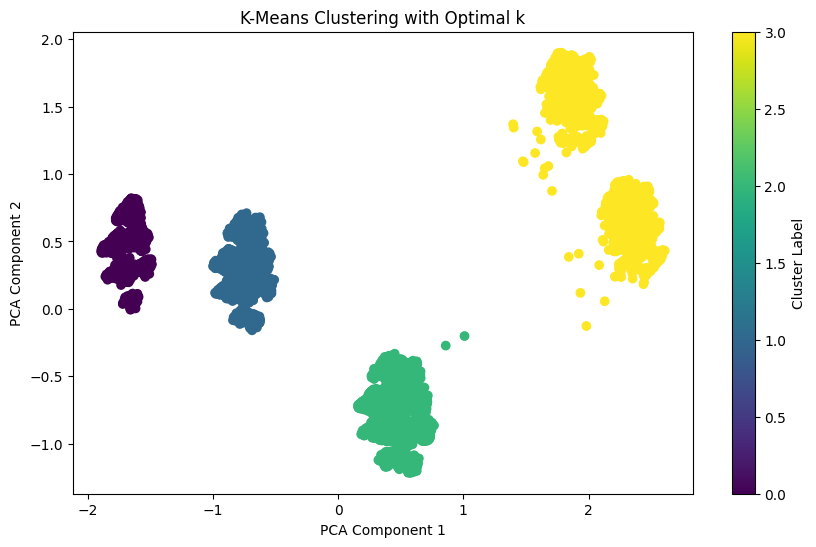

In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(final_data_encoded_df)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=final_labels, cmap='viridis')
plt.title('K-Means Clustering with Optimal k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [173]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data_encoded_df)
    inertia.append(kmeans.inertia_)

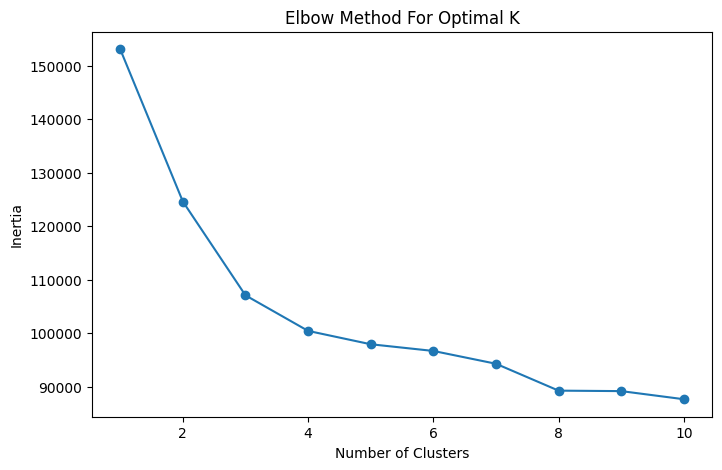

In [174]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [175]:
final_data_encoded_df['kmeans_cluster'].value_counts()

kmeans_cluster
2    9325
1    5694
0    4672
3    3652
Name: count, dtype: int64

In [176]:
engagement_columns = [
    'assessment_engagement_score',
    'module_engagement_rate',
    'weighted_engagement',
    'engagement_consistency',
    'learning_pace',
    'engagement_dropoff',
    'activity_diversity'
]

In [177]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 0
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(final_data_encoded_df[engagement_columns])
    score = silhouette_score(final_data_encoded_df[engagement_columns], labels)
    print(f'For k = {k}, Silhouette Score = {score}')
    if score > best_score:
        best_score = score
        best_k = k

print(f'Best k: {best_k}, Best Silhouette Score: {best_score}')

For k = 2, Silhouette Score = 0.4614188894120966
For k = 3, Silhouette Score = 0.3972163011036673
For k = 4, Silhouette Score = 0.4147318085099011
For k = 5, Silhouette Score = 0.35767672207409235
For k = 6, Silhouette Score = 0.3335858721755259
For k = 7, Silhouette Score = 0.3528991877240418
Best k: 2, Best Silhouette Score: 0.4614188894120966


In [178]:
kmeans = KMeans(n_clusters=3, random_state=42)
final_labels = kmeans.fit_predict(final_data_encoded_df[engagement_columns])

final_data_encoded_df['kmeans_cluster'] = final_labels

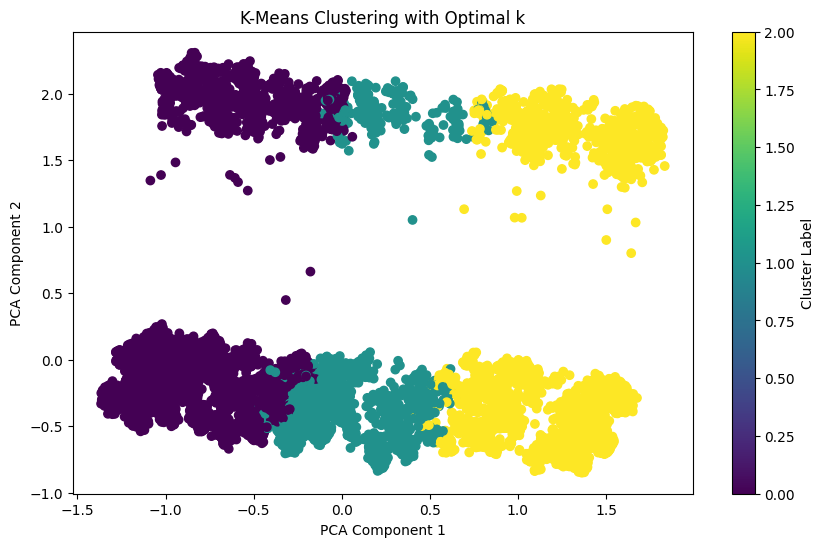

In [179]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(final_data_encoded_df)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=final_labels, cmap='viridis')
plt.title('K-Means Clustering with Optimal k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

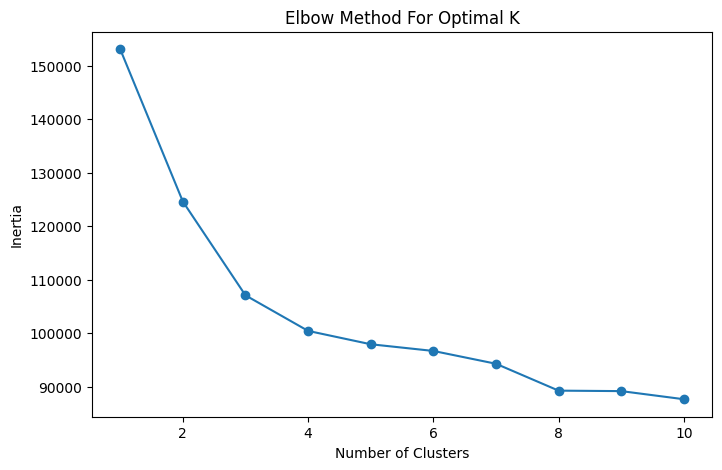

In [180]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [181]:
for col in engagement_columns:
    print(pd.DataFrame(final_data_encoded_df.groupby('kmeans_cluster')[col].describe()))

                  count      mean       std       min       25%       50%  \
kmeans_cluster                                                              
0               11843.0  0.008934  0.017370  0.000007  0.001245  0.003697   
1                4157.0  0.040133  0.066887  0.000171  0.010966  0.020803   
2                7343.0  0.002683  0.006882  0.000000  0.000191  0.000694   

                     75%       max  
kmeans_cluster                      
0               0.009118  0.381597  
1               0.040445  1.000000  
2               0.002183  0.151266  
                  count      mean       std       min       25%       50%  \
kmeans_cluster                                                              
0               11843.0  0.058666  0.045380  0.001625  0.027101  0.047693   
1                4157.0  0.140981  0.090161  0.007636  0.087918  0.118067   
2                7343.0  0.030862  0.029665  0.000000  0.010689  0.021836   

                     75%       max  
kmeans

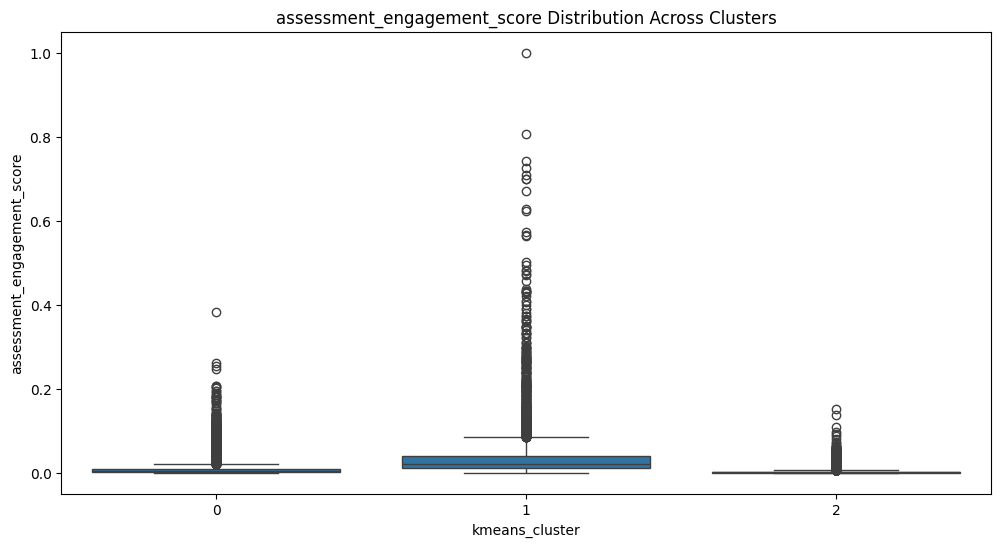

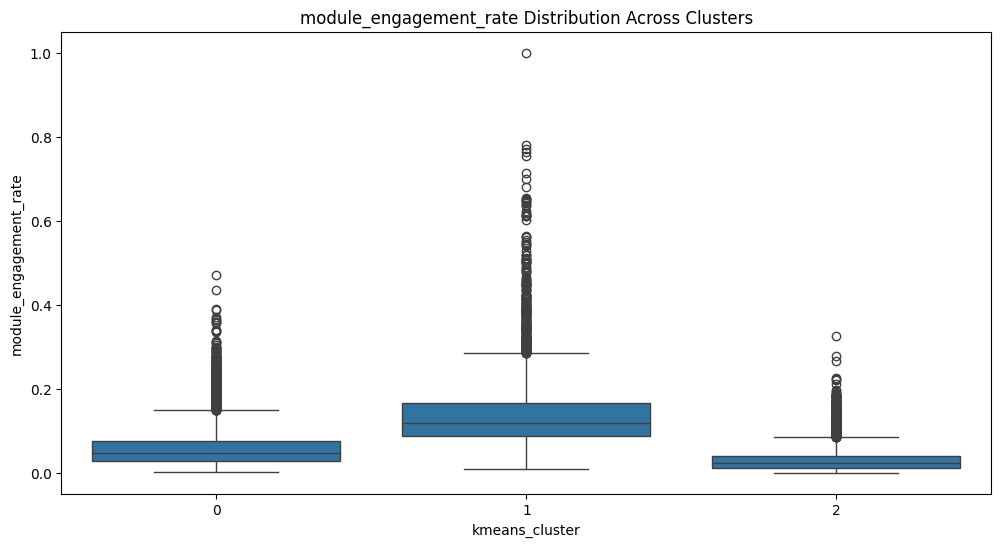

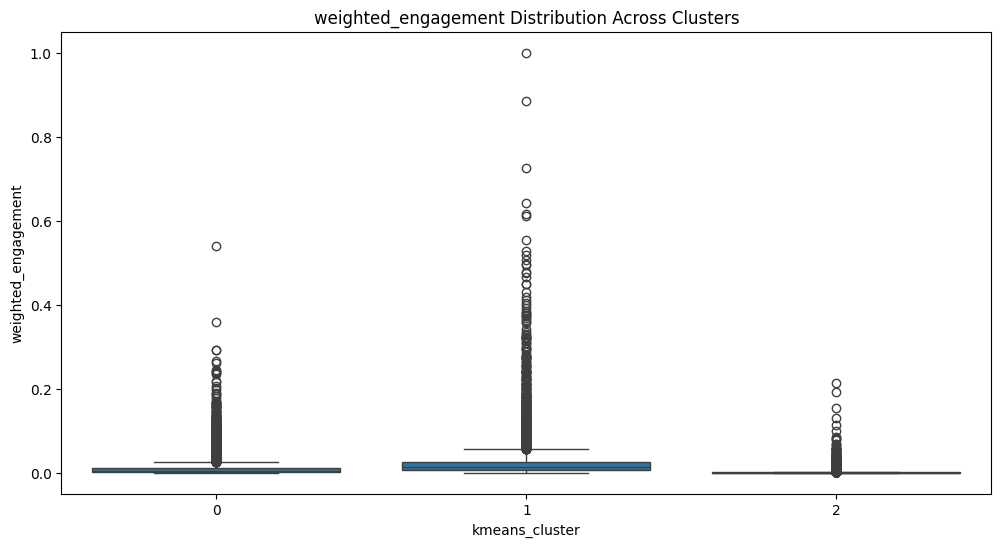

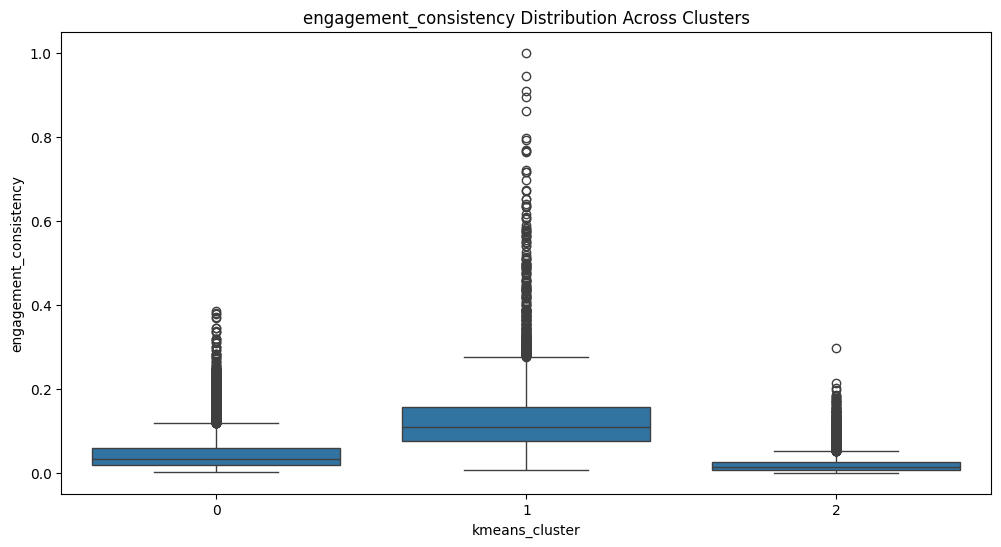

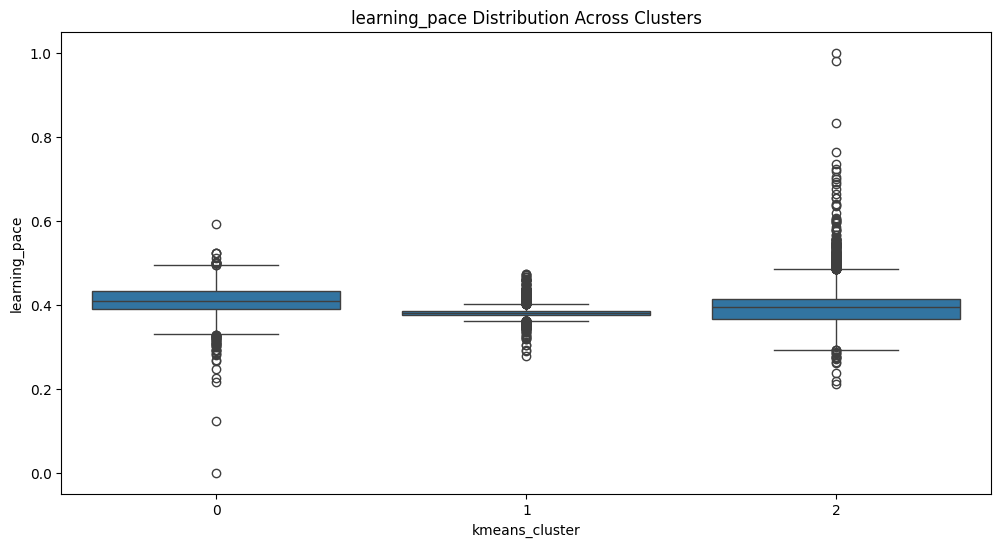

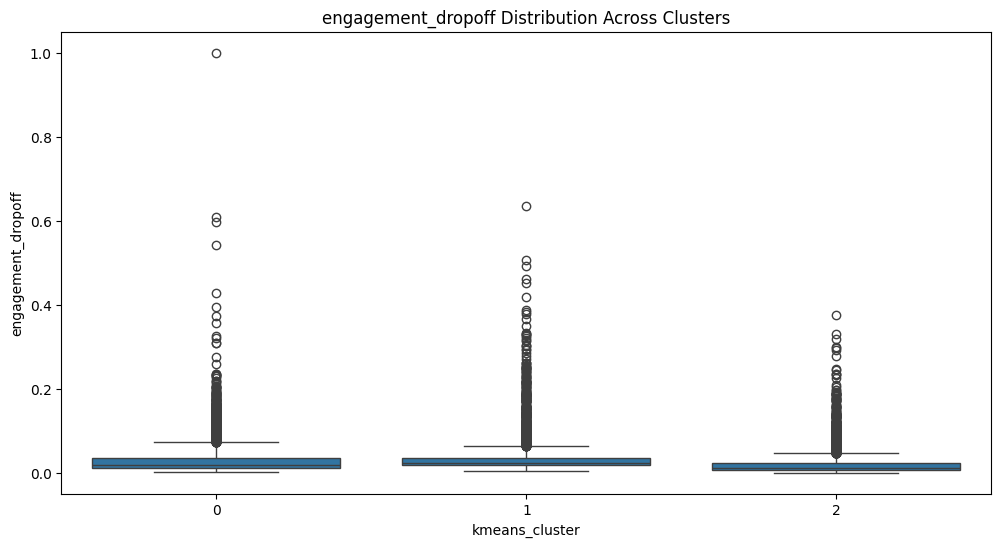

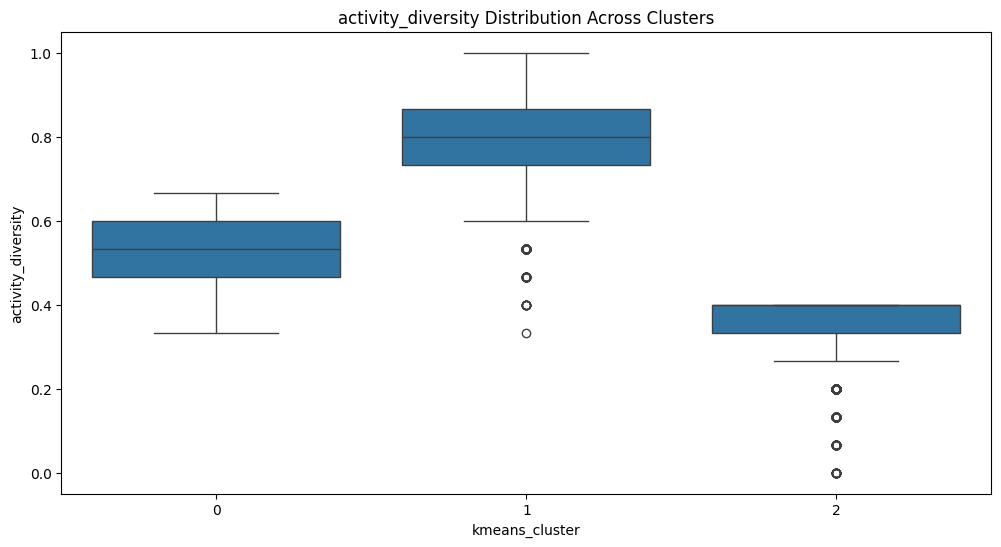

In [182]:
for col in engagement_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='kmeans_cluster', y=col, data=final_data_encoded_df)
    plt.title(f'{col} Distribution Across Clusters')
    plt.show()

assessment_engagement_score - ANOVA p-value: nan
module_engagement_rate - ANOVA p-value: nan
weighted_engagement - ANOVA p-value: nan
engagement_consistency - ANOVA p-value: nan
learning_pace - ANOVA p-value: nan
engagement_dropoff - ANOVA p-value: nan
activity_diversity - ANOVA p-value: nan


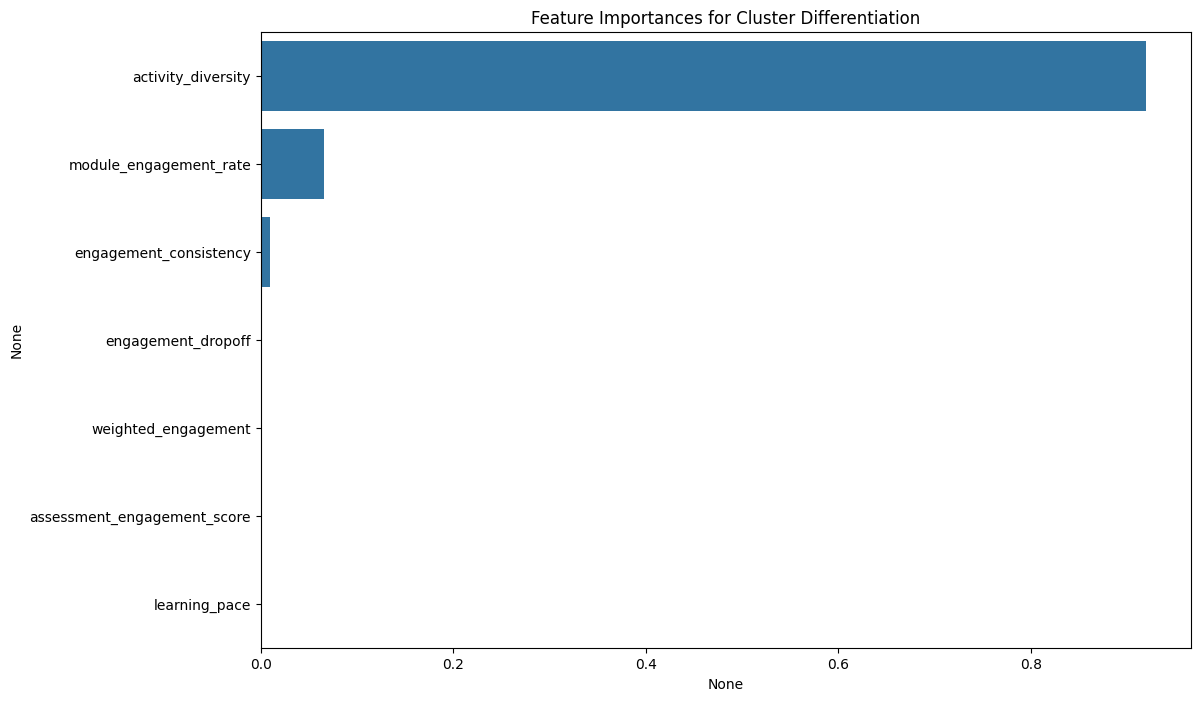

In [183]:
from scipy import stats
from sklearn.tree import DecisionTreeClassifier

for col in engagement_columns:
    f_stat, p_value = stats.f_oneway(*[final_data_encoded_df[final_data_encoded_df['kmeans_cluster'] == i][col] for i in range(4)])  # Adjust range if number of clusters is different
    print(f'{col} - ANOVA p-value: {p_value}')

X = final_data_encoded_df[engagement_columns]
y = final_data_encoded_df['kmeans_cluster']

model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=engagement_columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances for Cluster Differentiation')
plt.show()

In [184]:
df=final_data_encoded_df.copy()

In [185]:
engagement_columns = [
    'assessment_engagement_score', 'module_engagement_rate', 'weighted_engagement',
    'engagement_consistency', 'learning_pace', 'engagement_dropoff', 'activity_diversity'
]

cluster_summary = df.groupby('kmeans_cluster')[engagement_columns].describe().unstack()
cluster_summary

                                    kmeans_cluster
assessment_engagement_score  count  0                 11843.000000
                                    1                  4157.000000
                                    2                  7343.000000
                             mean   0                     0.008934
                                    1                     0.040133
                                                          ...     
activity_diversity           75%    1                     0.866667
                                    2                     0.400000
                             max    0                     0.666667
                                    1                     1.000000
                                    2                     0.400000
Length: 168, dtype: float64

In [186]:
df['average_engagement'] = df[engagement_columns].mean(axis=1)

def classify_engagement(row):
    if row['average_engagement'] > df['average_engagement'].quantile(0.75):
        return 'High Engagement'
    elif row['average_engagement'] < df['average_engagement'].quantile(0.25):
        return 'Low Engagement'
    else:
        return 'Moderate Engagement'

df['engagement_classification'] = df.apply(classify_engagement, axis=1)

In [187]:
df.engagement_classification.value_counts()

engagement_classification
Moderate Engagement    11671
High Engagement         5836
Low Engagement          5836
Name: count, dtype: int64

In [188]:
classification_summary = df.groupby(['kmeans_cluster', 'engagement_classification']).size().unstack(fill_value=0)
classification_summary

engagement_classification,High Engagement,Low Engagement,Moderate Engagement
kmeans_cluster,,,
0,1784,376,9683
1,3967,0,190
2,85,5460,1798


In [189]:
df = pd.concat([df,study_method],axis=1)
df.head()

,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_quiz,activity_type_resource,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,imd_band_0-10%,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35+,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn,study_status_finished,study_status_unfinished,withdrawal_status_didn't withdraw,withdrawal_status_early withdrawal,withdrawal_status_late withdrawal,withdrawal_status_normal withdrawal,sum,count,score,num_of_prev_attempts,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate,kmeans_cluster,average_engagement,engagement_classification,study_method_preference
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.046918,0.055064,0.618000,0.000000,0.027572,0.584637,0.032258,0.156095,0.000000,0.496875,0.038912,0.073336,0.118661,0.470793,0.097390,0.400000,0.644654,2,0.187060,High Engagement,Informational
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.006647,0.015226,0.873077,0.051282,0.001379,0.544713,0.070656,0.020121,0.307692,0.497121,0.001298,0.116558,0.017075,0.349810,0.013270,0.533333,0.623966,0,0.133755,Moderate Engagement,Collaborative
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.015699,0.016291,0.820000,0.000000,0.004209,0.586641,0.043282,0.060931,0.000000,0.500565,0.005940,0.084399,0.046766,0.489130,0.042164,0.333333,0.633268,2,0.140353,Moderate Engagement,Informational
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.002162,0.003911,0.825000,0.333333,0.000268,0.599917,0.286206,0.013771,1.000000,0.493776,0.000118,0.058792,0.007565,0.363658,0.009982,0.266667,0.567693,2,0.094576,Low Engagement,Offline Content
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.024475,0.040586,0.737500,0.000000,0.003367,0.593967,0.087350,0.044251,0.000000,0.499725,0.002970,0.160185,0.043693,0.420277,0.020365,0.466667,0.623440,0,0.143084,Moderate Engagement,Collaborative


In [190]:
df['engagement_classification'].value_counts()

engagement_classification
Moderate Engagement    11671
High Engagement         5836
Low Engagement          5836
Name: count, dtype: int64

In [191]:
df["study_method_preference"].value_counts()

study_method_preference
Collaborative      9942
Offline Content    6932
Interactive        3435
Informational      2571
Resource-Based      463
Name: count, dtype: int64

In [192]:
method_mapping = {
    'Collaborative': 0,
    'Offline Content': 1,
    'Interactive': 2,
    'Informational': 3,
    'Resource-Based': 4
}

# Apply the mapping to the 'study_method_preference' column
df['study_method_preference'] = df['study_method_preference'].map(method_mapping)

# Verify the changes
print(df['study_method_preference'].value_counts())

study_method_preference
0    9942
1    6932
2    3435
3    2571
4     463
Name: count, dtype: int64


In [193]:
le = LabelEncoder()
df['engagement_classification'] = le.fit_transform(df["engagement_classification"])

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop(columns='study_method_preference')
y = df['study_method_preference'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## classification on learning style

In [195]:
Svc_model = SVC(C = 1, kernel = 'linear')
logistic_model = LogisticRegression(C = 1, solver = 'lbfgs')
Knn_model = KNeighborsClassifier(n_neighbors = 7)
Naive_model = GaussianNB()
dt_model = DecisionTreeClassifier(random_state = 42)
rf_model = RandomForestClassifier(random_state = 42)
adaboost_model = AdaBoostClassifier(random_state = 42)
gradientboost_model = GradientBoostingClassifier(random_state = 42)
xgboost_model = XGBClassifier(random_state=42)

In [196]:
models = {
    'SVM': Svc_model,
    'Logistic Regression': logistic_model,
    'KNN': Knn_model,
    'GaussianNB': Naive_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'AdaBoost': adaboost_model,
    'GradientBoost': gradientboost_model
}

# Initialize dictionaries to store accuracies
train_accuracies = {}
test_accuracies = {}

train_f1scores = {}
test_f1scores = {}

for model_name, model in models.items():
        model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        train_f1score = f1_score(y_train, train_predictions, average='weighted')
        test_f1score = f1_score(y_test, test_predictions,average='weighted')
        

        train_accuracies[f'{model_name}'] = train_accuracy
        test_accuracies[f'{model_name}'] = test_accuracy

        train_f1scores[f'{model_name}'] = train_f1score
        test_f1scores[f'{model_name}'] = test_f1score
        
        
        print(model_name)
        print('Classification Report for train')
        print(classification_report(y_train, train_predictions))
        print('Classification Report for test')
        print(classification_report(y_test, test_predictions))
        print('-'*50)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': list(train_accuracies.keys()),
    'Train Accuracy': list(train_accuracies.values()),
    'Test Accuracy': list(test_accuracies.values()),
    'Train F1score': list(train_f1scores.values()),
    'Test F1score': list(test_f1scores.values())
})

SVM
Classification Report for train
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6959
           1       0.89      0.97      0.93      4852
           2       0.88      0.89      0.89      2405
           3       0.82      0.67      0.74      1800
           4       1.00      0.01      0.02       324

    accuracy                           0.89     16340
   macro avg       0.90      0.69      0.70     16340
weighted avg       0.89      0.89      0.88     16340

Classification Report for test
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2983
           1       0.88      0.96      0.92      2080
           2       0.89      0.90      0.90      1030
           3       0.79      0.65      0.72       771
           4       1.00      0.03      0.06       139

    accuracy                           0.89      7003
   macro avg       0.90      0.69      0.70      7003
weighted a

In [197]:
results_df = results_df.sort_values(by='Test F1score', ascending=False)
results_df

,Model,Train Accuracy,Test Accuracy,Train F1score,Test F1score
7,GradientBoost,0.957711,0.932029,0.957019,0.930688
5,Random Forest,1.000000,0.921462,1.000000,0.917761
4,Decision Tree,1.000000,0.903613,1.000000,0.903581
0,SVM,0.887576,0.886906,0.876870,0.876651
1,Logistic Regression,0.881640,0.877053,0.870797,0.866131
2,KNN,0.792778,0.740254,0.777496,0.721195
6,AdaBoost,0.473684,0.471084,0.521382,0.517637
3,GaussianNB,0.418299,0.425960,0.481370,0.491879


In [198]:
svc_model = SVC(C=10, gamma='scale', kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)

SVC(C=10, kernel='linear', random_state=42)

In [199]:
print("Training Report")
y_pred_train = svc_model.predict(X_train)
print(classification_report(y_train,y_pred_train))

# Predict and Evaluate Models
print("\n Testing Report")
y_pred = svc_model.predict(X_test)
print(classification_report(y_test, y_pred))

Training Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6959
           1       0.97      0.99      0.98      4852
           2       0.88      0.90      0.89      2405
           3       0.90      0.91      0.91      1800
           4       0.85      0.53      0.65       324

    accuracy                           0.93     16340
   macro avg       0.91      0.85      0.87     16340
weighted avg       0.93      0.93      0.93     16340


 Testing Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2983
           1       0.96      0.98      0.97      2080
           2       0.89      0.90      0.89      1030
           3       0.89      0.89      0.89       771
           4       0.82      0.53      0.65       139

    accuracy                           0.93      7003
   macro avg       0.90      0.85      0.87      7003
weighted avg       0.93      0.93      0.93 

In [200]:
gb_model = GradientBoostingClassifier(random_state = 42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [201]:
print("Training Report")
y_pred_train = gb_model.predict(X_train)
print(classification_report(y_train,y_pred_train))

# Predict and Evaluate Models
print("\n Testing Report")
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Training Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6959
           1       0.98      1.00      0.99      4852
           2       0.94      0.93      0.94      2405
           3       0.96      0.89      0.92      1800
           4       0.91      0.67      0.77       324

    accuracy                           0.96     16340
   macro avg       0.95      0.89      0.92     16340
weighted avg       0.96      0.96      0.96     16340


 Testing Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2983
           1       0.96      0.99      0.97      2080
           2       0.91      0.90      0.91      1030
           3       0.90      0.81      0.86       771
           4       0.78      0.58      0.66       139

    accuracy                           0.93      7003
   macro avg       0.90      0.85      0.87      7003
weighted avg       0.93      0.93      0.93 

In [202]:
print("Train Acc:",round(accuracy_score(y_train,y_pred_train),2),"%")
print("Test Acc:",round(accuracy_score(y_test,y_pred),2),"%")

Train Acc: 0.96 %
Test Acc: 0.93 %


In [203]:
joblib.dump(svc_model, 'SVC.pkl')

['SVC.pkl']

In [204]:
joblib.dump(gb_model, 'GB.pkl')

['GB.pkl']

In [205]:
data = pd.concat([df,ids], axis=1)
data.to_csv("data.csv")

In [206]:
merged_df.head()

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,study_status,withdrawal_status,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,banked_assessment_ratio,time_since_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,17,0,60.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-2.0,5.454545,0.078067,0,-1.176471,0.0,71.0,840.0,60.0,491.833818,0.0,43.647059,7,0.5
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,51,0,48.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-3.0,2.285714,0.078067,0,-0.941176,0.0,106.0,1680.0,108.0,491.833818,34.0,43.647059,7,0.5
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,116,0,63.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-1.0,3.000000,0.078067,0,-1.235294,0.0,169.0,1680.0,171.0,491.833818,65.0,43.647059,7,0.5
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,164,0,61.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-2.0,2.904762,0.078067,0,-1.196078,0.0,218.0,1680.0,232.0,491.833818,48.0,43.647059,7,0.5
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,210,0,77.0,-52.0,M,Scotland,HE Qualification,80-90%,35+,0,60,N,Pass,269,finished,didn't withdraw,84,-5.0,2.483871,0.078067,0,-1.509804,0.0,267.0,2520.0,309.0,491.833818,46.0,43.647059,7,0.5


In [207]:
merged_df.shape

(1579985, 41)

## recommendation system

In [208]:
def recommend_learning_path(student_id):
    # Concatenate the DataFrame and IDs
    recomend_data = pd.concat([df, ids], axis=1)
    
    # Get the data for the specific student
    student_data = recomend_data[recomend_data['id_student'] == student_id]
    
    # Check if student exists in the data
    if student_data.empty:
        return "Student not found."
    
    # Remove unnecessary columns for prediction
    student_data.drop(columns=['id_student', 'study_method_preference'], inplace=True)
    
    # Predict the study method preference
    predicted_label = gb_model.predict(student_data)
    
    # Extract engagement level
    engagement = student_data["engagement_classification"].iloc[0]
    
    # Recommendations based on study method and engagement
    recommendations = {
        0: {  # Collaborative
            0: ["Interactive AI Basics: Weekly Quizzes and Forums","Applied AI: Practical Exercises with Peer Feedback"
               ,"Introduction to Machine Learning: Online Workshops","AI Ethics: Case Studies and Discussion Groups"],  # Moderate Engagement
            1: ["Collaborative AI Projects: Team-Based Learning","Advanced AI Techniques: Group Workshops and Peer Reviews"
               ,"Machine Learning Bootcamp: Intensive Group Projects","AI in Practice: Team Challenges and Hackathons"],      # High Engagement
            2: ['Introduction to AI: Self-Paced Fundamentals', 'AI Basics: Introductory Video Series',
                'Foundations of Machine Learning: Self-Study Edition','AI for Everyone: Introductory Readings and Quizzes'] # Low Engagement
        },
        1: {  # Offline Content
            0: ["AI Principles: Self-Study with Case Studies", "Machine Learning: Offline Course with Practice Problems",
                "Applied AI: Textbook and Supplementary Materials", "Data Science: Case Studies and Analytical Exercises"], # Moderate Engagement
            1: ["Advanced AI: Comprehensive Textbook with Projects", "Deep Learning: In-Depth Study with Capstone Projects",
               "AI and Machine Learning: Project-Based Learning", "Data Science Mastery: Offline Content with Comprehensive Projects"], # High Engagement
            2: ['AI Basics: Essential Readings and Key Concepts', 'Machine Learning Fundamentals: Self-Study Workbook',
               "AI Concepts: Downloadable Lecture Series", "Introduction to Data Science: Offline Learning Modules"] # Low Engagement
        },
        2: {  # Interactive
            0: ["Machine Learning: Interactive Coding Exercises", "AI Applications: Interactive Case Studies",
               "Data Science: Interactive Projects and Peer Reviews", "AI Ethics: Discussion Forums and Interactive Scenarios"], # Moderate Engagement
            1: ["Advanced AI: Interactive Group Projects and Hackathons", "Deep Learning: Interactive Labs and Collaborative Projects",
               "Machine Learning Mastery: Interactive Workshops and Challenges","AI Research: Collaborative Research Projects and Peer Feedback"], # High Engagement
            2: ["AI Basics: Interactive Quizzes and Flashcards", "Introduction to Machine Learning: Interactive Visualizations",
               "AI Fundamentals: Interactive Notebooks", "AI Concepts: Gamified Learning Modules"] # Low Engagement
        },
        3: {  # Informational
            0: ["Machine Learning: Structured Video Course", "AI Concepts: Comprehensive Video Series",
               "Data Science: Interactive Reading and Video Modules", "AI in Practice: Lecture Notes and Case Studies"], # Moderate Engagement
            1: ["Advanced AI: Detailed Lecture Series and Readings", "Deep Learning: Advanced Lecture Series with Supplemental Readings",
               "AI and Machine Learning: Research Papers and Advanced Lectures", "Data Science Masterclass: Comprehensive Reading and Video Content"], # High Engagement
            2: ["AI Overview: Short Video Lectures", "Introduction to Machine Learning: Podcast Series",
               "AI Fundamentals: Infographics and Summaries", "Data Science: Essential Readings and Articles"] # Low Engagement
        },
        4: {  # Resource-Based
            0: ["Machine Learning: Comprehensive eBooks and Guides", "AI Applications: Case Study Compilations",
               "Data Science: In-Depth Articles and White Papers", "AI Concepts: Research Articles and Detailed Guides"], # Moderate Engagement
            1: ["Advanced AI: Research Papers and Technical Reports", "Deep Learning: Comprehensive Textbooks and Resource Repositories",
               "Machine Learning Mastery: Advanced Documentation and APIs", "AI Ethics: Government and Institutional Reports"], # High Engagement
            2: ["AI Basics: Curated Reading Lists", "Introduction to Machine Learning: Beginner-Friendly Blogs",
               "Data Science Overview: Quick Reference Guides", "AI Fundamentals: Online Documentation"] # Low Engagement
        }
    }
    
    # Determine study method and engagement level
    study_method = predicted_label[0]
    engagement_level = engagement.iloc[0] if isinstance(engagement, pd.Series) else engagement
    
    # Get the recommended courses based on study method and engagement level
    recommended_courses = recommendations.get(study_method, {}).get(engagement_level, [])

    return recommended_courses, study_method, engagement_level

In [209]:
def return_map_to_original_preference(x):
    if x == 0:
        return 'Collaborative'
    elif x == 1:
        return 'Offline Content'
    elif x == 2:
        return 'Interactive'
    elif x==3:
        return 'Informational'
    elif x==4:
        return 'Resource-Based'

In [210]:
def return_map_to_original_engagement(x):
    if x == 0:
        return 'Moderate Engagement'
    elif x == 1:
        return 'High Engagement'
    elif x == 2:
        return 'Low Engagement'

In [211]:
data.sample(1)[["id_student","study_method_preference","engagement_classification"]]

,id_student,study_method_preference,engagement_classification
2772,348579,0,1


In [212]:
df.head()

,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_quiz,activity_type_resource,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,imd_band_0-10%,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35+,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn,study_status_finished,study_status_unfinished,withdrawal_status_didn't withdraw,withdrawal_status_early withdrawal,withdrawal_status_late withdrawal,withdrawal_status_normal withdrawal,sum,count,score,num_of_prev_attempts,assessment_engagement_score,submission_timeliness,score_per_weight,module_engagement_rate,repeat_student,performance_by_registration,weighted_engagement,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate,kmeans_cluster,average_engagement,engagement_classification,study_method_preference
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.046918,0.055064,0.618000,0.000000,0.027572,0.584637,0.032258,0.156095,0.000000,0.496875,0.038912,0.073336,0.118661,0.470793,0.097390,0.400000,0.644654,2,0.187060,0,3
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.006647,0.015226,0.873077,0.051282,0.001379,0.544713,0.070656,0.020121,0.307692,0.497121,0.001298,0.116558,0.017075,0.349810,0.013270,0.533333,0.623966,0,0.133755,2,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.015699,0.016291,0.820000,0.000000,0.004209,0.586641,0.043282,0.060931,0.000000,0.500565,0.005940,0.084399,0.046766,0.489130,0.042164,0.333333,0.633268,2,0.140353,2,3
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.002162,0.003911,0.825000,0.333333,0.000268,0.599917,0.286206,0.013771,1.000000,0.493776,0.000118,0.058792,0.007565,0.363658,0.009982,0.266667,0.567693,2,0.094576,1,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.024475,0.040586,0.737500,0.000000,0.003367,0.593967,0.087350,0.044251,0.000000,0.499725,0.002970,0.160185,0.043693,0.420277,0.020365,0.466667,0.623440,0,0.143084,2,0


In [229]:
# Get recommendations for a student
student_id = 677111

recommendations, study_method, engegement = recommend_learning_path(student_id)
study_method = return_map_to_original_preference(study_method)
engegement = return_map_to_original_engagement(engegement)

print(f"Study method preference for student {student_id}: {study_method}")
print(f"Level of engagement for student {student_id}: {engegement}")
print(f"Recommended courses for student {student_id}: {recommendations}")

Study method preference for student 677111: Interactive
Level of engagement for student 677111: Moderate Engagement
Recommended courses for student 677111: ['Machine Learning: Interactive Coding Exercises', 'AI Applications: Interactive Case Studies', 'Data Science: Interactive Projects and Peer Reviews', 'AI Ethics: Discussion Forums and Interactive Scenarios']


In [214]:
# def recommend_learning_path_cosine(student_id, df, feature_columns, id_column="student_id", top_n=3):
#     """
#     Recommend a learning path for a student using cosine similarity.

#     Parameters:
#         student_id (int): The ID of the student for whom to make recommendations.
#         df (pd.DataFrame): The dataset containing student/course information.
#         feature_columns (list): The columns to use for calculating similarity.
#         id_column (str): The column name for student IDs. Defaults to "student_id".
#         top_n (int): The number of recommendations to return. Defaults to 3.

#     Returns:
#         tuple: Recommended courses, study method, and engagement level.
#     """
#     if student_id not in df[id_column].values:
#         return "Student not found.", None, None
    
#     # Extract feature matrix
#     feature_matrix = df[feature_columns].values
    
#     # Compute cosine similarity
#     similarity_matrix = cosine_similarity(feature_matrix)
    
#     # Get the index of the target student
#     student_index = df[df[id_column] == student_id].index[0]
    
#     # Get similarity scores for the target student
#     similarity_scores = similarity_matrix[student_index]
    
#     # Sort indices by similarity, excluding the student itself
#     similar_indices = similarity_scores.argsort()[::-1][1:top_n+1]
    
#     # Fetch recommendations
#     recommended_courses = df.iloc[similar_indices]["course_recommendation"].tolist()
    
#     # Retrieve the target student's study method and engagement level
#     study_method = df.loc[student_index, "study_method"]
#     engagement = df.loc[student_index, "engagement_level"]
    
#     return recommended_courses, study_method, engagement


In [215]:
# # Function to map numeric preferences to their original labels
# def return_map_to_original_preference(x):
#     mapping = {
#         0: "Collaborative",
#         1: "Offline Content",
#         2: "Interactive",
#         3: "Informational",
#         4: "Resource-Based"
#     }
#     return mapping.get(x, "Unknown Preference")

# # Function to map numeric engagement levels to their original labels
# def return_map_to_original_engagement(x):
#     mapping = {
#         0: "Moderate Engagement",
#         1: "High Engagement",
#         2: "Low Engagement"
#     }
#     return mapping.get(x, "Unknown Engagement")

# # Recommendations dictionary
# recommendations = {
#     0: {
#         0: ["Interactive AI Basics: Weekly Quizzes and Forums", "Applied AI: Practical Exercises with Peer Feedback",
#             "Introduction to Machine Learning: Online Workshops", "AI Ethics: Case Studies and Discussion Groups"],
#         1: ["Collaborative AI Projects: Team-Based Learning", "Advanced AI Techniques: Group Workshops and Peer Reviews",
#             "Machine Learning Bootcamp: Intensive Group Projects", "AI in Practice: Team Challenges and Hackathons"],
#         2: ['Introduction to AI: Self-Paced Fundamentals', 'AI Basics: Introductory Video Series',
#             'Foundations of Machine Learning: Self-Study Edition', 'AI for Everyone: Introductory Readings and Quizzes']
#     },
#     1: {
#         0: ["AI Principles: Self-Study with Case Studies", "Machine Learning: Offline Course with Practice Problems",
#             "Applied AI: Textbook and Supplementary Materials", "Data Science: Case Studies and Analytical Exercises"],
#         1: ["Advanced AI: Comprehensive Textbook with Projects", "Deep Learning: In-Depth Study with Capstone Projects",
#             "AI and Machine Learning: Project-Based Learning", "Data Science Mastery: Offline Content with Comprehensive Projects"],
#         2: ['AI Basics: Essential Readings and Key Concepts', 'Machine Learning Fundamentals: Self-Study Workbook',
#             "AI Concepts: Downloadable Lecture Series", "Introduction to Data Science: Offline Learning Modules"]
#     },
#     2: {
#         0: ["Machine Learning: Interactive Coding Exercises", "AI Applications: Interactive Case Studies",
#             "Data Science: Interactive Projects and Peer Reviews", "AI Ethics: Discussion Forums and Interactive Scenarios"],
#         1: ["Advanced AI: Interactive Group Projects and Hackathons", "Deep Learning: Interactive Labs and Collaborative Projects",
#             "Machine Learning Mastery: Interactive Workshops and Challenges", "AI Research: Collaborative Research Projects and Peer Feedback"],
#         2: ["AI Basics: Interactive Quizzes and Flashcards", "Introduction to Machine Learning: Interactive Visualizations",
#             "AI Fundamentals: Interactive Notebooks", "AI Concepts: Gamified Learning Modules"]
#     },
#     3: {
#         0: ["Machine Learning: Structured Video Course", "AI Concepts: Comprehensive Video Series",
#             "Data Science: Interactive Reading and Video Modules", "AI in Practice: Lecture Notes and Case Studies"],
#         1: ["Advanced AI: Detailed Lecture Series and Readings", "Deep Learning: Advanced Lecture Series with Supplemental Readings",
#             "AI and Machine Learning: Research Papers and Advanced Lectures", "Data Science Masterclass: Comprehensive Reading and Video Content"],
#         2: ["AI Overview: Short Video Lectures", "Introduction to Machine Learning: Podcast Series",
#             "AI Fundamentals: Infographics and Summaries", "Data Science: Essential Readings and Articles"]
#     },
#     4: {
#         0: ["Machine Learning: Comprehensive eBooks and Guides", "AI Applications: Case Study Compilations",
#             "Data Science: In-Depth Articles and White Papers", "AI Concepts: Research Articles and Detailed Guides"],
#         1: ["Advanced AI: Research Papers and Technical Reports", "Deep Learning: Comprehensive Textbooks and Resource Repositories",
#             "Machine Learning Mastery: Advanced Documentation and APIs", "AI Ethics: Government and Institutional Reports"],
#         2: ["AI Basics: Curated Reading Lists", "Introduction to Machine Learning: Beginner-Friendly Blogs",
#             "Data Science Overview: Quick Reference Guides", "AI Fundamentals: Online Documentation"]
#     }
# }

# # Function to get recommendations based on study method and engagement level
# def get_recommendations(student_id, df, id_column="student_id", study_column="study_method", engagement_column="engagement_level"):
#     """
#     Retrieve recommendations for a student based on their study method and engagement level.

#     Parameters:
#         student_id (int): The ID of the student.
#         df (pd.DataFrame): The dataset containing student information.
#         id_column (str): Column name for student IDs. Default is "student_id".
#         study_column (str): Column name for study method. Default is "study_method".
#         engagement_column (str): Column name for engagement level. Default is "engagement_level".

#     Returns:
#         tuple: Recommendations, study method label, and engagement level label.
#     """
#     if student_id not in df[id_column].values:
#         return "Student not found.", None, None

#     # Get the student's row
#     student_row = df[df[id_column] == student_id].iloc[0]

#     # Extract study method and engagement level
#     study_method = student_row[study_column]
#     engagement_level = student_row[engagement_column]

#     # Retrieve recommendations
#     recommended_courses = recommendations.get(study_method, {}).get(engagement_level, [])

#     # Map study method and engagement level to original labels
#     study_method_label = return_map_to_original_preference(study_method)
#     engagement_level_label = return_map_to_original_engagement(engagement_level)

#     return recommended_courses, study_method_label, engagement_level_label

# # Example DataFrame
# import pandas as pd

# df = pd.DataFrame(data)

# # Example usage
# student_id = 677111
# recommended_courses, study_method, engagement_level = get_recommendations(student_id, df)

# # Output results
# print(f"Study method for student {student_id}: {study_method}")
# print(f"Engagement level for student {student_id}: {engagement_level}")
# print(f"Recommended courses for student {student_id}: {recommended_courses}")


In [216]:
# Get recommendations for a student
student_id = 677111

recommendations, study_method, engegement = recommend_learning_path(student_id)
study_method = return_map_to_original_preference(study_method)
engegement = return_map_to_original_engagement(engegement)

print(f"Study method preference for student {student_id}: {study_method}")
print(f"Level of engagement for student {student_id}: {engegement}")
print(f"Recommended courses for student {student_id}: {recommendations}")

Study method preference for student 677111: Interactive
Level of engagement for student 677111: Moderate Engagement
Recommended courses for student 677111: ['Machine Learning: Interactive Coding Exercises', 'AI Applications: Interactive Case Studies', 'Data Science: Interactive Projects and Peer Reviews', 'AI Ethics: Discussion Forums and Interactive Scenarios']


In [217]:
# Get recommendations for a student
student_id = 645019

recommendations, study_method, engegement = recommend_learning_path(student_id)
study_method = return_map_to_original_preference(study_method)
engegement = return_map_to_original_engagement(engegement)

print(f"Study method preference for student {student_id}: {study_method}")
print(f"Level of engagement for student {student_id}: {engegement}")
print(f"Recommended courses for student {student_id}: {recommendations}")

Study method preference for student 645019: Offline Content
Level of engagement for student 645019: Low Engagement
Recommended courses for student 645019: ['AI Basics: Essential Readings and Key Concepts', 'Machine Learning Fundamentals: Self-Study Workbook', 'AI Concepts: Downloadable Lecture Series', 'Introduction to Data Science: Offline Learning Modules']


In [221]:
# Get recommendations for a student
student_id = 645020

recommendations, study_method, engegement = recommend_learning_path(student_id)
study_method = return_map_to_original_preference(study_method)
engegement = return_map_to_original_engagement(engegement)

print(f"Study method preference for student {student_id}: {study_method}")
print(f"Level of engagement for student {student_id}: {engegement}")
print(f"Recommended courses for student {student_id}: {recommendations}")

Study method preference for student 645020: Interactive
Level of engagement for student 645020: Moderate Engagement
Recommended courses for student 645020: ['Machine Learning: Interactive Coding Exercises', 'AI Applications: Interactive Case Studies', 'Data Science: Interactive Projects and Peer Reviews', 'AI Ethics: Discussion Forums and Interactive Scenarios']


In [226]:
# Get recommendations for a student
student_id = 52130

recommendations, study_method, engegement = recommend_learning_path(student_id)
study_method = return_map_to_original_preference(study_method)
engegement = return_map_to_original_engagement(engegement)

print(f"Study method preference for student {student_id}: {study_method}")
print(f"Level of engagement for student {student_id}: {engegement}")
print(f"Recommended courses for student {student_id}: {recommendations}")

Study method preference for student 52130: Informational
Level of engagement for student 52130: Low Engagement
Recommended courses for student 52130: ['AI Overview: Short Video Lectures', 'Introduction to Machine Learning: Podcast Series', 'AI Fundamentals: Infographics and Summaries', 'Data Science: Essential Readings and Articles']
